# TEAM CONTRIBUTIONS

**Team Members:** Tina, Andrew, Rellikson

### **TINA - EDA Specialist & Data Quality Lead**
**Primary Role:** Exploratory Data Analysis and foundational data understanding
**Responsibilities:**
- Overall dataset inspection and structure analysis
- Target variable distribution analysis (critical for imbalanced data)
- Missing value pattern identification across all variables
- Data quality assessment (duplicates, outliers, anomalies)
- Baseline statistics and distributions
- Visualization of key patterns
- Foundation insights that guide team preprocessing decisions

##**ANDREW - Categorical & Temporal Processing Specialist**
**Primary Role:** Handle categorical encoding and temporal variable transformations
**Variables Assigned:**
- **Temporal Variables:** DAYS_BIRTH, DAYS_EMPLOYED, DAYS_REGISTRATION, DAYS_ID_PUBLISH, DAYS_LAST_PHONE_CHANGE
- **Categorical Variables:** All categorical variables (CODE_GENDER, NAME_* variables, FLAG_* variables)
- **High-Cardinality Variables:** OCCUPATION_TYPE, ORGANIZATION_TYPE (special encoding needed)
- **Missing Value Strategy:** Systematic imputation approach for all variable types
- **Document Flags:** FLAG_DOCUMENT_* variables (21 document verification flags)

### **RELLIKSON - Feature Engineering**
**Variables Assigned:**
- **Deterministic Features in PART 1:** ratios/products and document completeness (no train-time fitting)
- **ML-Derived Features (moved to PART 2):** KMeans segments, IsolationForest anomalies, statistical feature selection

## 1. Setup and Imports

In [ ]:
# !pip install scikit-learn imbalanced-learn pandas numpy matplotlib plotnine joblib seaborn category-encoders xgboost lightgbm shap

In [1]:
# Imports
import pandas as pd
import numpy as np
from plotnine import *
import matplotlib.pyplot as plt
import warnings, os, json
from IPython.display import display
from pathlib import Path

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)

In [2]:
# Plot theme
theme_set(
    theme_minimal()
    + theme(
        figure_size=(18, 8),
        text=element_text(size=11),
        plot_title=element_text(size=16, fontweight="bold"),
        plot_subtitle=element_text(size=12, fontstyle="italic"),
        axis_title=element_text(size=12),
        axis_text=element_text(size=10),
        legend_text=element_text(size=10),
        legend_position="bottom",
    )
)

In [3]:
# Paths
RAW_CSV = "Case_Data.csv"
OUT_DIR = Path("processed_data")
OUT_DIR.mkdir(parents=True, exist_ok=True)
ARTIFACT_DIR = Path("artifacts")
ARTIFACT_DIR.mkdir(parents=True, exist_ok=True)

# 2. Data Exploration (EDA) - Tina

## Data Loading

In [4]:
df = pd.read_csv(RAW_CSV)
print("Dataset shape:", df.shape)

Dataset shape: (20000, 68)


## 2a. General Overview of the Dataset

In [5]:
# Quick peek
display(df.head())

TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
0       0         Cash loans           M            Y               N   
1       0         Cash loans           M            Y               Y   
2       0         Cash loans           M            N               N   
3       0         Cash loans           F            N               Y   
4       0         Cash loans           F            N               Y   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             1          225000.0    918468.0      28966.5         697500.0   
1             0          157500.0    299772.0      20160.0         247500.0   
2             0          108000.0    509602.5      26149.5         387000.0   
3             0           90000.0    225000.0      11074.5         225000.0   
4             0          112500.0    512064.0      25033.5         360000.0   

  NAME_TYPE_SUITE NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
0   Unaccompanied          Working  Secondary / secondary special   
1          Family          Working  Secondary / secondary special   
2   Unaccompanied          Working  Secondary / secondary special   
3   Unaccompanied          Working  Secondary / secondary special   
4          Family          Working  Secondary / secondary special   

     NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  REGION_POPULATION_RELATIVE  \
0               Married  House / apartment                    0.016612   
1  Single / not married   Rented apartment                    0.020713   
2               Married  House / apartment                    0.018634   
3               Married  House / apartment                    0.028663   
4        Civil marriage  House / apartment                    0.008575   

   DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  \
0      -14086          -3028               -643            -4911   
1       -8728          -1157              -3494            -1368   
2      -12931          -1317              -6392            -3866   
3      -19334          -3494              -2419            -2893   
4      -11144          -1104              -7846            -2904   

   FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  \
0               1                0                 1           0           0   
1               1                0                 1           0           0   
2               1                0                 1           0           0   
3               1                0                 1           1           0   
4               1                0                 1           0           0   

         OCCUPATION_TYPE  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
0                Drivers                3                     2   
1               Laborers                1                     3   
2                Drivers                2                     2   
3         Cleaning staff                2                     2   
4  Private service staff                2                     2   

   REGION_RATING_CLIENT_W_CITY WEEKDAY_APPR_PROCESS_START  \
0                            2                   THURSDAY   
1                            3                   SATURDAY   
2                            2                   THURSDAY   
3                            2                   SATURDAY   
4                            2                    TUESDAY   

   HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
0                       13                           0   
1                        6                           0   
2                       12                           0   
3                        8                           0   
4                       12                           0   

   REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  \
0                           0                            0   
1                           0                            0   
2                           0     

In [6]:
# Calculate basic dataset dimensions
n_rows, n_cols = df.shape          # Number of loan applications and variables
n_predictors = n_cols - 1            # All variables except TARGET

# Display the dataset size information
print("Dataset Dimensions:")
print(f"- Total observations (rows): {n_rows:,}")
print(f"- Total variables (columns): {n_cols}")
print(f"- Predictor variables: {n_predictors}")
print(f"- Response variable: 1 (TARGET)")

Dataset Dimensions:
- Total observations (rows): 20,000
- Total variables (columns): 68
- Predictor variables: 67
- Response variable: 1 (TARGET)


In [7]:
# Classify variables by type
all_cols = df.columns.tolist()

# Get numeric and categorical variables
numeric_vars = df.select_dtypes(include=[np.number]).columns.tolist()
if 'TARGET' in numeric_vars:
    numeric_vars.remove('TARGET')

categorical_vars = df.select_dtypes(include=['object']).columns.tolist()

# Specific variable types based on naming patterns
date_vars = [col for col in numeric_vars if 'DAYS_' in col]
flag_vars = [col for col in all_cols if 'FLAG_' in col]
amt_vars = [col for col in all_cols if 'AMT_' in col]
cnt_vars = [col for col in all_cols if 'CNT_' in col]
ext_vars = [col for col in all_cols if 'EXT_SOURCE' in col]

other_numeric = [col for col in numeric_vars 
                if col not in date_vars + amt_vars + cnt_vars + ext_vars]

# Create classification summary
var_classification = {
    'Categorical': categorical_vars,
    'Financial Amounts': amt_vars,
    'Date Variables': date_vars,
    'Flag Variables': flag_vars,
    'Count Variables': cnt_vars,
    'External Scores': ext_vars,
    'Other Numeric': other_numeric
}

print("Variable Classification Summary:")
for var_type, vars_list in var_classification.items():
    print(f"  {var_type}: {len(vars_list)} variables")
    if vars_list:
        examples = ', '.join(vars_list[:3])
        if len(vars_list) > 3:
            examples += f" (and {len(vars_list)-3} more)"
        print(f"    Examples: {examples}")

Variable Classification Summary:
  Categorical: 12 variables
    Examples: NAME_CONTRACT_TYPE, CODE_GENDER, FLAG_OWN_CAR (and 9 more)
  Financial Amounts: 10 variables
    Examples: AMT_INCOME_TOTAL, AMT_CREDIT, AMT_ANNUITY (and 7 more)
  Date Variables: 5 variables
    Examples: DAYS_BIRTH, DAYS_EMPLOYED, DAYS_REGISTRATION (and 2 more)
  Flag Variables: 24 variables
    Examples: FLAG_OWN_CAR, FLAG_OWN_REALTY, FLAG_EMP_PHONE (and 21 more)
  Count Variables: 6 variables
    Examples: CNT_CHILDREN, CNT_FAM_MEMBERS, OBS_30_CNT_SOCIAL_CIRCLE (and 3 more)
  External Scores: 2 variables
    Examples: EXT_SOURCE_2, EXT_SOURCE_3
  Other Numeric: 32 variables
    Examples: REGION_POPULATION_RELATIVE, FLAG_EMP_PHONE, FLAG_WORK_PHONE (and 29 more)


## Selected Most Important Features for Loan Default Prediction

In [8]:
# Below are the columns we prioritize for analysis and modeling, with short reasons.
important_features = [
    # External scores
    "EXT_SOURCE_2", 
    "EXT_SOURCE_3",
    
    # Demographics & stability
    "DAYS_BIRTH",             # Age (younger clients riskier)
    "DAYS_EMPLOYED",          # Employment stability
    "OCCUPATION_TYPE",        # Type of job (income stability proxy)
    "ORGANIZATION_TYPE",      # Type of employer
    
    # Financial amounts
    "AMT_INCOME_TOTAL",       # Client income
    "AMT_CREDIT",             # Loan credit amount
    "AMT_ANNUITY",            # Repayment burden
    "AMT_GOODS_PRICE",        # Value of purchased goods
    # Ratios (engineered later)
    # "Credit_to_Goods_Ratio", "Annuity_to_Credit_Ratio"
    
    # Region and environment
    "REGION_RATING_CLIENT", 
    "REGION_RATING_CLIENT_W_CITY",
    
    # Social environment risk
    "OBS_30_CNT_SOCIAL_CIRCLE",
    "DEF_30_CNT_SOCIAL_CIRCLE",
    "OBS_60_CNT_SOCIAL_CIRCLE",
    "DEF_60_CNT_SOCIAL_CIRCLE",
    
    # Bureau requests (credit hunger)
    "AMT_REQ_CREDIT_BUREAU_DAY",
    "AMT_REQ_CREDIT_BUREAU_WEEK",
    "AMT_REQ_CREDIT_BUREAU_MON",
    "AMT_REQ_CREDIT_BUREAU_QRT",
    "AMT_REQ_CREDIT_BUREAU_YEAR",

    # Identification & verification flags
    "DAYS_ID_PUBLISH",        # ID age (new IDs riskier)
    "FLAG_PHONE",             # Phone provided
    "DAYS_LAST_PHONE_CHANGE",  # Phone stability

    # "FLAG_OWN_CAR", "FLAG_OWN_REALTY"  # Ownership flags (less predictive)
    "FLAG_OWN_CAR",           # Car ownership
    "FLAG_OWN_REALTY",        # Realty ownership

    # Family & housing status (less predictive)
    "NAME_FAMILY_STATUS",     # Marital status
    "NAME_HOUSING_TYPE",      # Housing situation
    "NAME_EDUCATION_TYPE"     # Education level
]

print("Important features selected:", important_features)

Important features selected: ['EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'DAYS_ID_PUBLISH', 'FLAG_PHONE', 'DAYS_LAST_PHONE_CHANGE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'NAME_EDUCATION_TYPE']


In [9]:
df = df[important_features + ['TARGET']]
print("Reduced dataset shape:", df.shape)

Reduced dataset shape: (20000, 30)


In [10]:
# Target distribution
df["TARGET"].value_counts(normalize=True)

TARGET
0    0.92255
1    0.07745
Name: proportion, dtype: float64

In [11]:
# Duplicates
duplicate_count = df.duplicated().sum()
display(pd.DataFrame({'Duplicate_Rows':[duplicate_count]}))

Duplicate_Rows
0               0

In [12]:
# Nicely formatted counts
if "TARGET" in df.columns:
    target_counts = df["TARGET"].value_counts().sort_index()
    target_pct = df["TARGET"].value_counts(normalize=True).sort_index() * 100
    print("\nTarget Variable Distribution:")
    if 0 in target_counts.index:
        print(
            f" 0 (No Payment Difficulties): {target_counts[0]:,} ({target_pct[0]:.1f}%)"
        )
    if 1 in target_counts.index:
        print(f" 1 (Payment Difficulties): {target_counts[1]:,} ({target_pct[1]:.1f}%)")


Target Variable Distribution:
 0 (No Payment Difficulties): 18,451 (92.3%)
 1 (Payment Difficulties): 1,549 (7.7%)


Target Variable Distribution:
  0 (No Payment Difficulties): 18,451 (92.3%)
  1 (Payment Difficulties):    1,549 (7.7%)


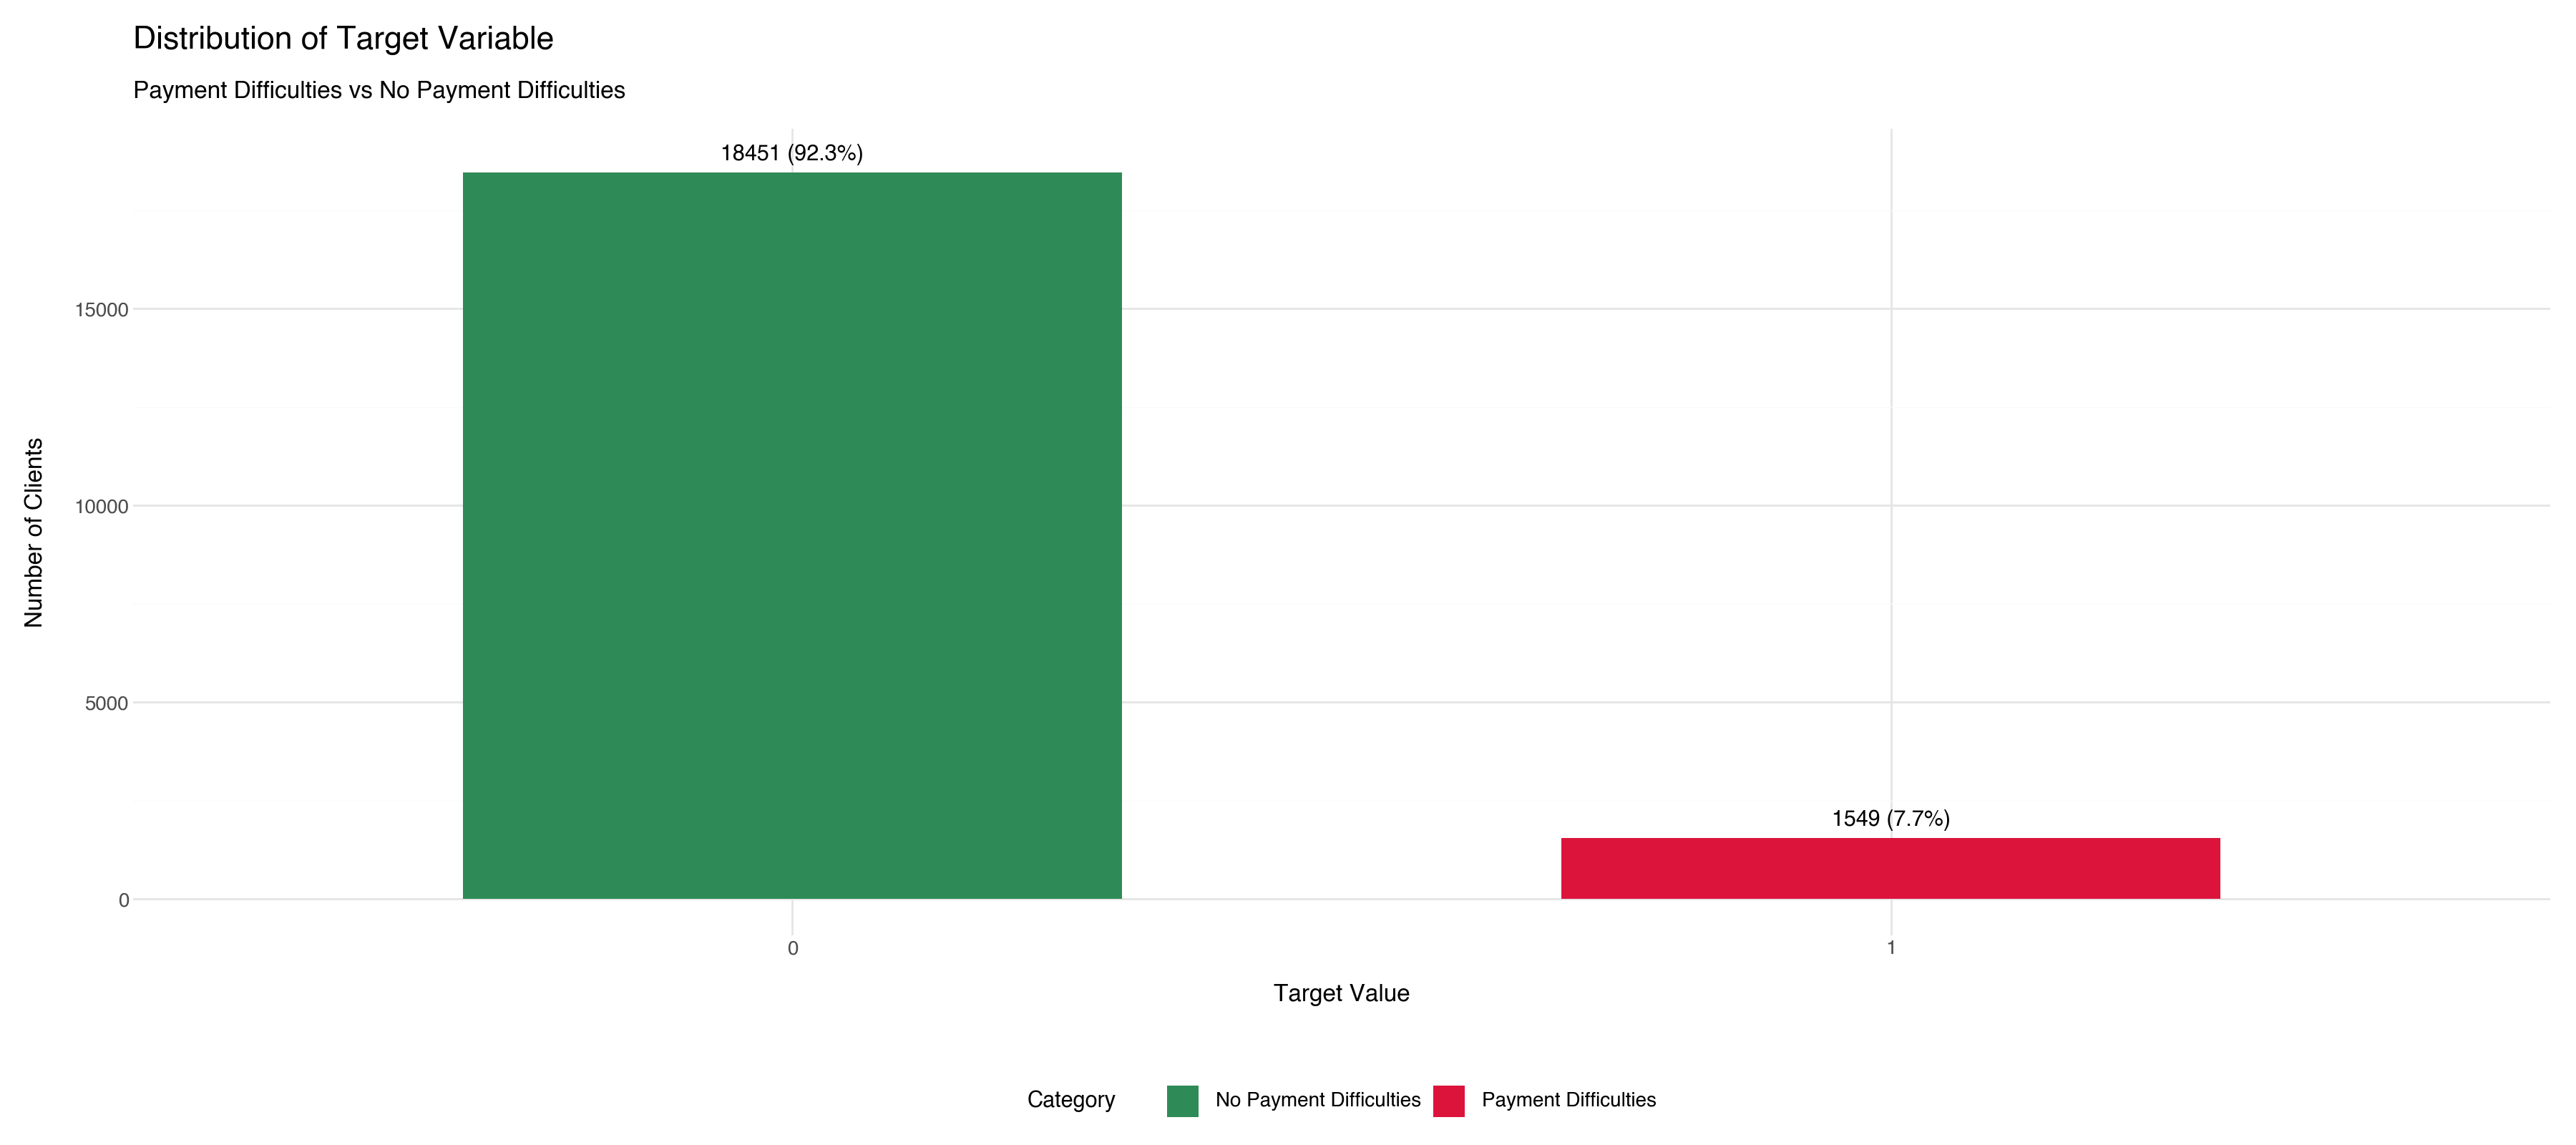

In [13]:
# Analyze our target variable - who had payment difficulties vs who didn't
target_counts = df['TARGET'].value_counts().sort_index()
target_pct = df['TARGET'].value_counts(normalize=True).sort_index() * 100

print("Target Variable Distribution:")
print(f"  0 (No Payment Difficulties): {target_counts[0]:,} ({target_pct[0]:.1f}%)")
print(f"  1 (Payment Difficulties):    {target_counts[1]:,} ({target_pct[1]:.1f}%)")

# Prepare data for visualization
target_summary = (df.groupby('TARGET')
                 .size()
                 .reset_index(name='count')
                 .assign(
                     percentage=lambda x: round(x['count'] / x['count'].sum() * 100, 1),
                     label=lambda x: x['TARGET'].map({0: 'No Payment Difficulties', 1: 'Payment Difficulties'})
                 ))

# Add formatted labels to dataframe for display on chart
target_summary['label_text'] = (target_summary['count'].astype(str) + 
                               ' (' + target_summary['percentage'].astype(str) + '%)')

# Create a bar chart to visualize the balance of our outcome variable
plot = (ggplot(target_summary, aes(x='factor(TARGET)', y='count', fill='label')) +
        geom_col(width=0.6) +
        # Add labels showing counts and percentages on the bars
        geom_text(aes(label='label_text'), 
                 va='bottom', nudge_y=target_summary['count'].max() * 0.01, 
                 size=11, fontweight='bold') +
        # Use green for good outcomes, red for payment difficulties
        scale_fill_manual(values={'No Payment Difficulties': '#2E8B57', 
                                'Payment Difficulties': '#DC143C'}) +
        labs(title='Distribution of Target Variable',
             subtitle='Payment Difficulties vs No Payment Difficulties',
             x='Target Value',
             y='Number of Clients',
             fill='Category'))

plot

In [14]:
# Missing values analysis
missing_data = df.isnull().sum()
missing_pct = (missing_data / len(df)) * 100
missing_summary = (pd.DataFrame({'Variable': missing_data.index, 'Missing_Count': missing_data.values, 'Missing_Percentage': missing_pct.values})
.query('Missing_Count > 0').sort_values('Missing_Count', ascending=False))
print('\nMissing Values Summary:')
print(f"Total variables with missing values: {len(missing_summary)}")
print(f"Variables with >50% missing: {sum(missing_summary['Missing_Percentage'] > 50)}")
print(f"Variables with >20% missing: {sum(missing_summary['Missing_Percentage'] > 20)}")
if len(missing_summary) > 0:
    display(missing_summary.head(10).round(2))


Missing Values Summary:
Total variables with missing values: 14
Variables with >50% missing: 0
Variables with >20% missing: 1


Variable  Missing_Count  Missing_Percentage
4              OCCUPATION_TYPE           6290               31.45
1                 EXT_SOURCE_3           3945               19.73
17  AMT_REQ_CREDIT_BUREAU_WEEK           2701               13.50
18   AMT_REQ_CREDIT_BUREAU_MON           2701               13.50
19   AMT_REQ_CREDIT_BUREAU_QRT           2701               13.50
16   AMT_REQ_CREDIT_BUREAU_DAY           2701               13.50
20  AMT_REQ_CREDIT_BUREAU_YEAR           2701               13.50
15    DEF_60_CNT_SOCIAL_CIRCLE             54                0.27
13    DEF_30_CNT_SOCIAL_CIRCLE             54                0.27
12    OBS_30_CNT_SOCIAL_CIRCLE             54                0.27

In [15]:
full_data_missing_values=df.isnull().sum().sum()
print("Total missing values in full dataset:", full_data_missing_values)

Total missing values in full dataset: 24023


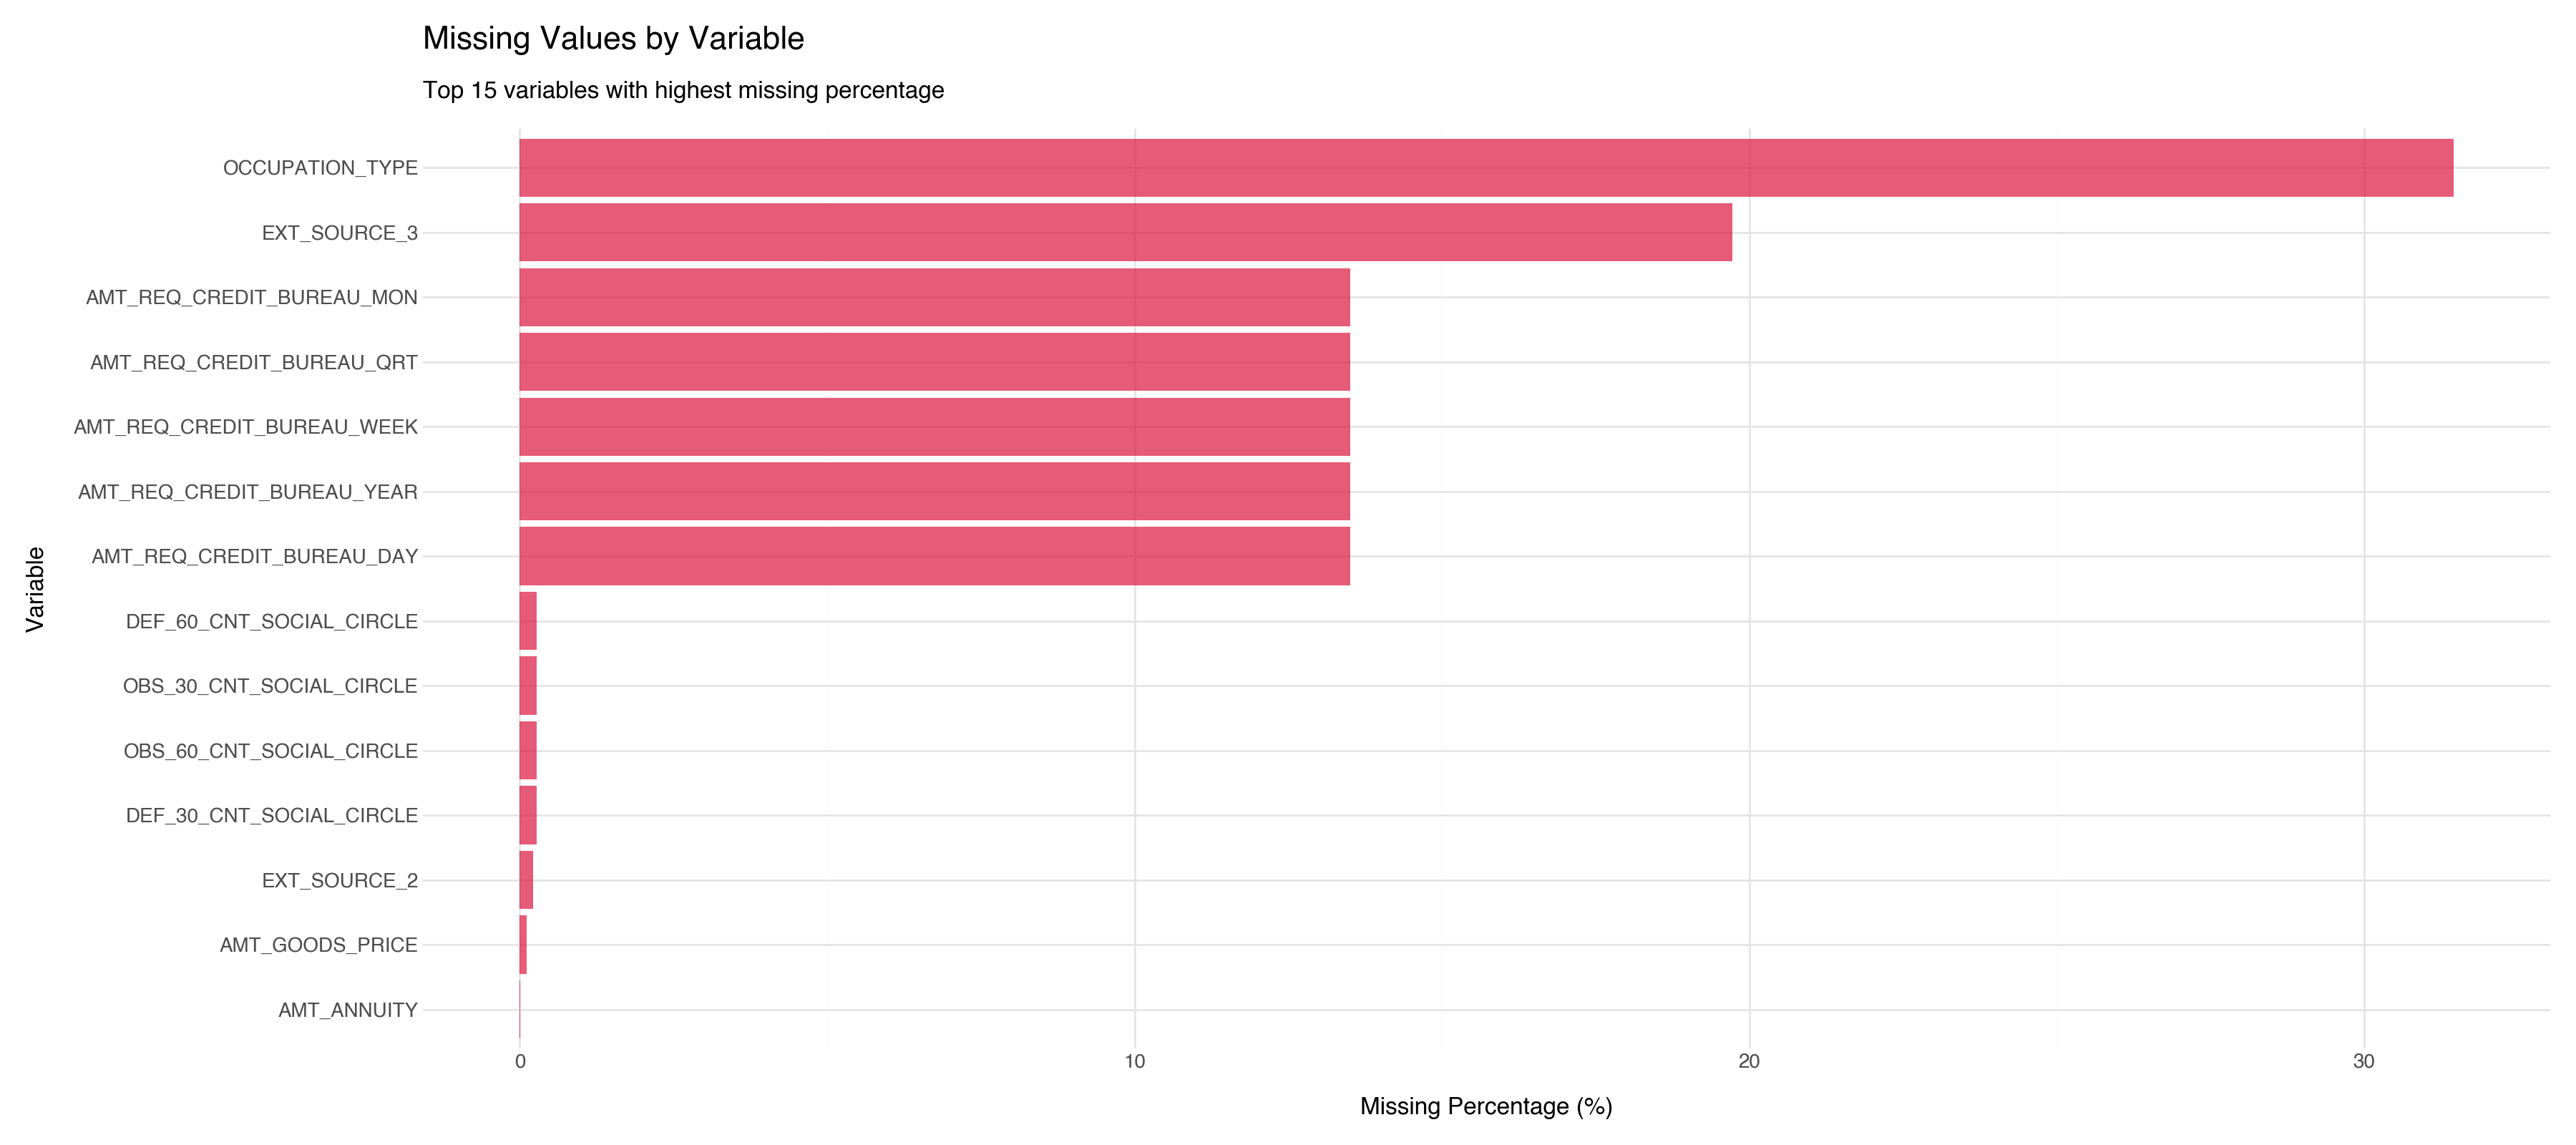

In [16]:
# Visualize missing values using plotnine (FIXED)
if len(missing_summary) > 0:
    top_missing = missing_summary.head(15)  # Top 15
    
    plot = (ggplot(top_missing, aes(x='reorder(Variable, Missing_Percentage)', y='Missing_Percentage')) +
            geom_col(fill='#DC143C', alpha=0.7) +
            coord_flip() +
            labs(title='Missing Values by Variable',
                 subtitle='Top 15 variables with highest missing percentage',
                 x='Variable',
                 y='Missing Percentage (%)'))
else:
    print("No missing values to visualize.")
plot


In [17]:
# Simple outliers for key money fields
key_money = [c for c in ['AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY'] if c in df.columns]
out_rows = []
for col in key_money:
    s = df[col].dropna()
    if s.empty:
        continue
    q1, q3 = s.quantile(0.25), s.quantile(0.75)
    iqr = q3 - q1
    low, high = q1 - 1.5*iqr, q3 + 1.5*iqr
    out_count = int(((s < low) | (s > high)).sum())
    out_pct = round(out_count / len(s) * 100, 2)
    out_rows.append({'column': col, 'outliers': out_count, 'pct': out_pct})
    display(pd.DataFrame(out_rows))

column  outliers   pct
0  AMT_INCOME_TOTAL       882  4.41

column  outliers   pct
0  AMT_INCOME_TOTAL       882  4.41
1        AMT_CREDIT       451  2.25

column  outliers   pct
0  AMT_INCOME_TOTAL       882  4.41
1        AMT_CREDIT       451  2.25
2       AMT_ANNUITY       498  2.49

### Data Quality Summary

**Key Findings:**

1. **Missing Values**: The dataset shows varying levels of missing data across variables, with some variables having substantial missing rates that may require to drop the variable or impute the missing values.
2. **Outliers**: Financial variables show expected outliers in income and credit amounts, which is typical in financial data and may represent legitimate high-value cases.
3. **Data Consistency**: Most variables show expected ranges and formats, with date variables properly encoded as days before application.

**Implications for Analysis:**

- The data seems to be clean and consistent, with no major issues found. The two variables with missing data  are

| Variable        | Missing Count | Missing Percentage |
|:----------------|:--------------|:-------------------|
| OCCUPATION_TYPE | 6290         | 31.45              |
| EXT_SOURCE_3    | 3945         | 19.73              |


- Outliers in financial variables may need treatment depending on analysis goals. For example

| Variable         | Outliers | Percentage |
|:-----------------|:---------|:-----------|
| AMT_INCOME_TOTAL | 882      | 4.41%      |
| AMT_CREDIT       | 451      | 2.26%      |
| AMT_ANNUITY      | 498      | 2.49%      |

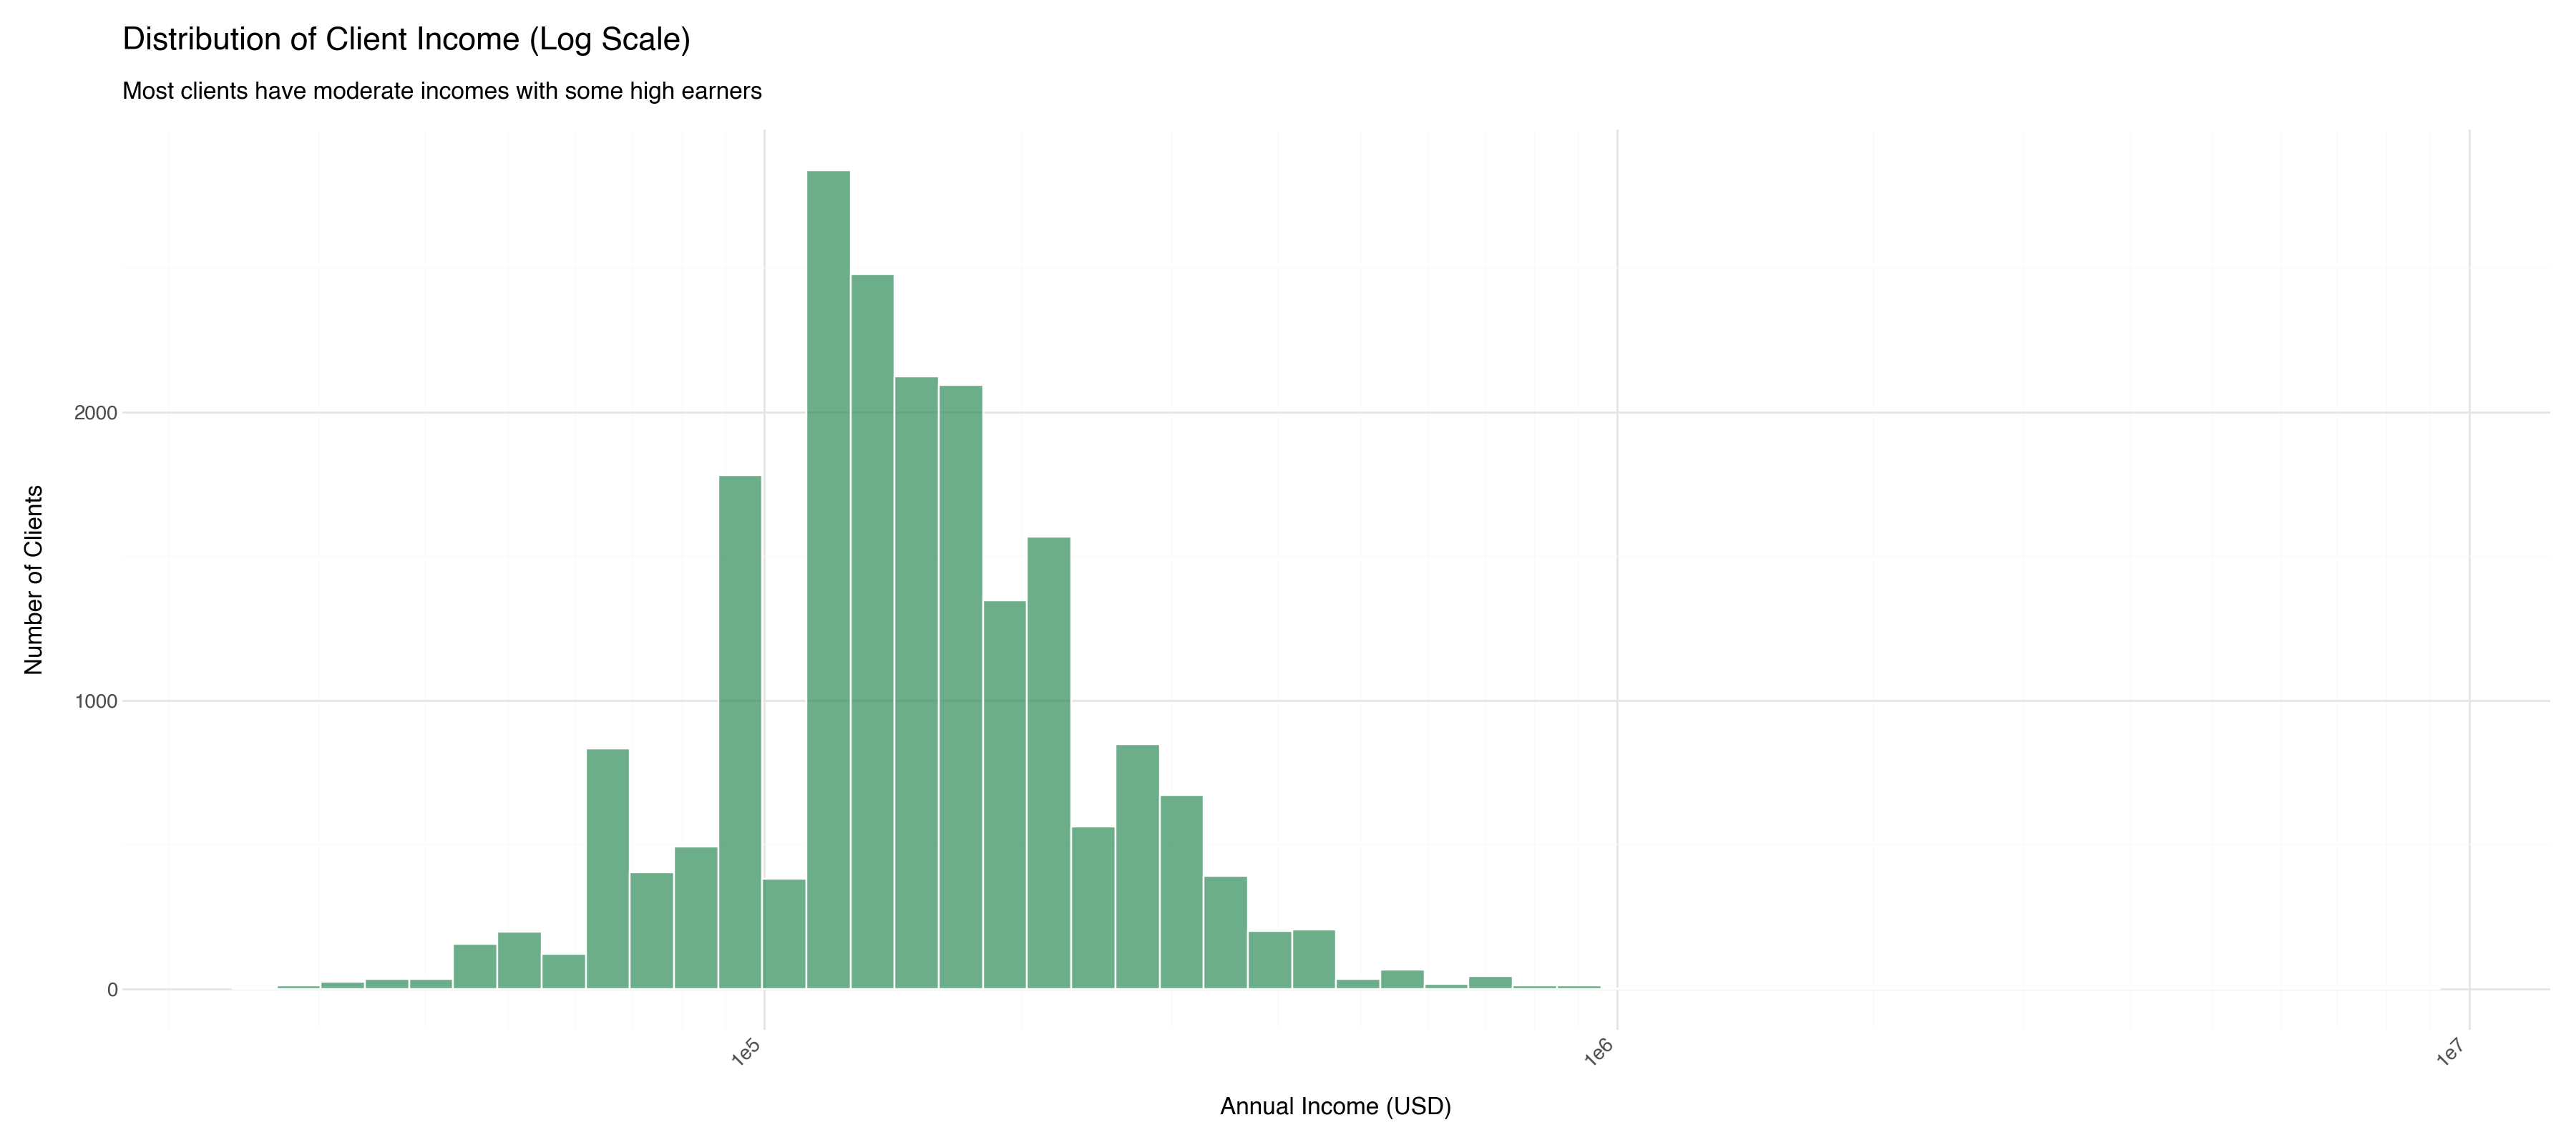

In [18]:
# Income distribution
if 'AMT_INCOME_TOTAL' in df.columns:
    income_data = df[df['AMT_INCOME_TOTAL'].notna() & (df['AMT_INCOME_TOTAL'] > 0)]
    plot = (ggplot(income_data, aes(x='AMT_INCOME_TOTAL')) +
    geom_histogram(bins=50, fill='#2E8B57', alpha=0.7, color='white') +
    scale_x_log10() +
    labs(title='Distribution of Client Income (Log Scale)', subtitle='Most clients have moderate incomes with some high earners', x='Annual Income (USD)', y='Number of Clients') +
    theme(axis_text_x=element_text(rotation=45, hjust=1)))
plot

**Purpose**: This compares the income levels of people who successfully paid back their loans versus those who struggled with payments - basically, does money matter?

**Business Takeaway**: Yes, it really matters! People with lower incomes are much more likely to have trouble paying back loans. This tells us we need to be extra careful with loan amounts for lower-income borrowers and maybe offer them additional support or financial guidance.


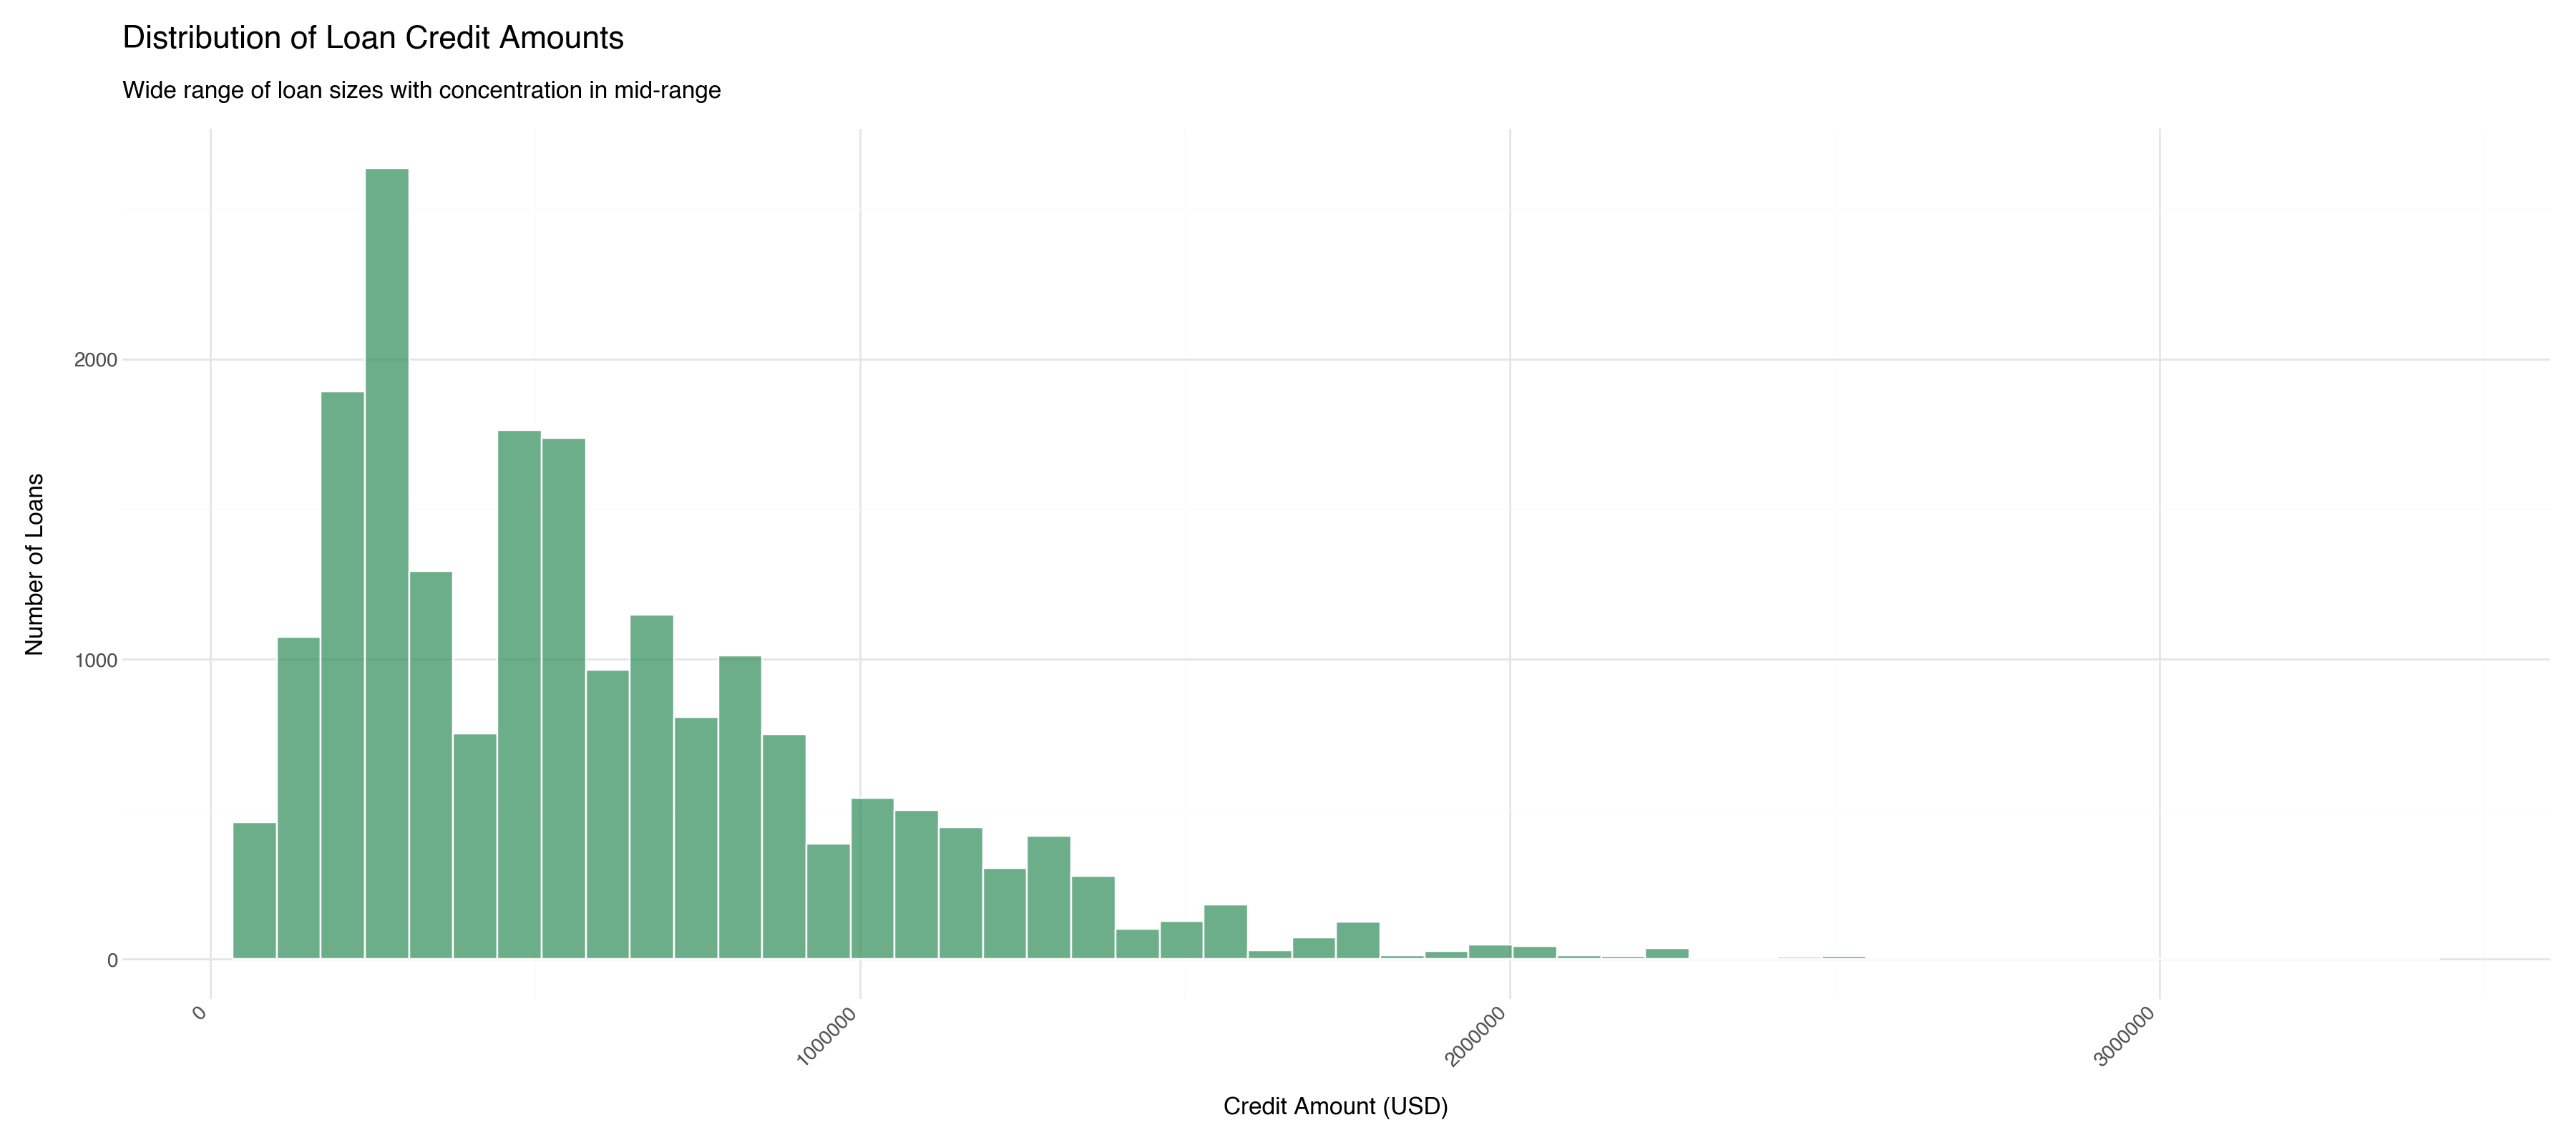

In [19]:
# Single variable analysis - Credit amount distribution
credit_data = df[df['AMT_CREDIT'].notna() & (df['AMT_CREDIT'] > 0)]

# Create histogram showing the range of loan amounts
plot = (ggplot(credit_data, aes(x='AMT_CREDIT')) +
        geom_histogram(bins=50, fill='#2E8B57', alpha=0.7, color='white') +
        scale_x_continuous() +
        labs(title='Distribution of Loan Credit Amounts',
             subtitle='Wide range of loan sizes with concentration in mid-range',
             x='Credit Amount (USD)',
             y='Number of Loans') +
        theme(axis_text_x=element_text(rotation=45, hjust=1)))
plot

**Purpose**: This shows us the range of loan amounts people are asking for and getting approved for - are most loans small, large, or somewhere in between?

**Business Takeaway**: We're serving people with all kinds of borrowing needs, from small personal loans to bigger purchases. Most loans fall in the middle range, which suggests we have some standard loan packages, but we also handle both smaller and larger requests when needed.

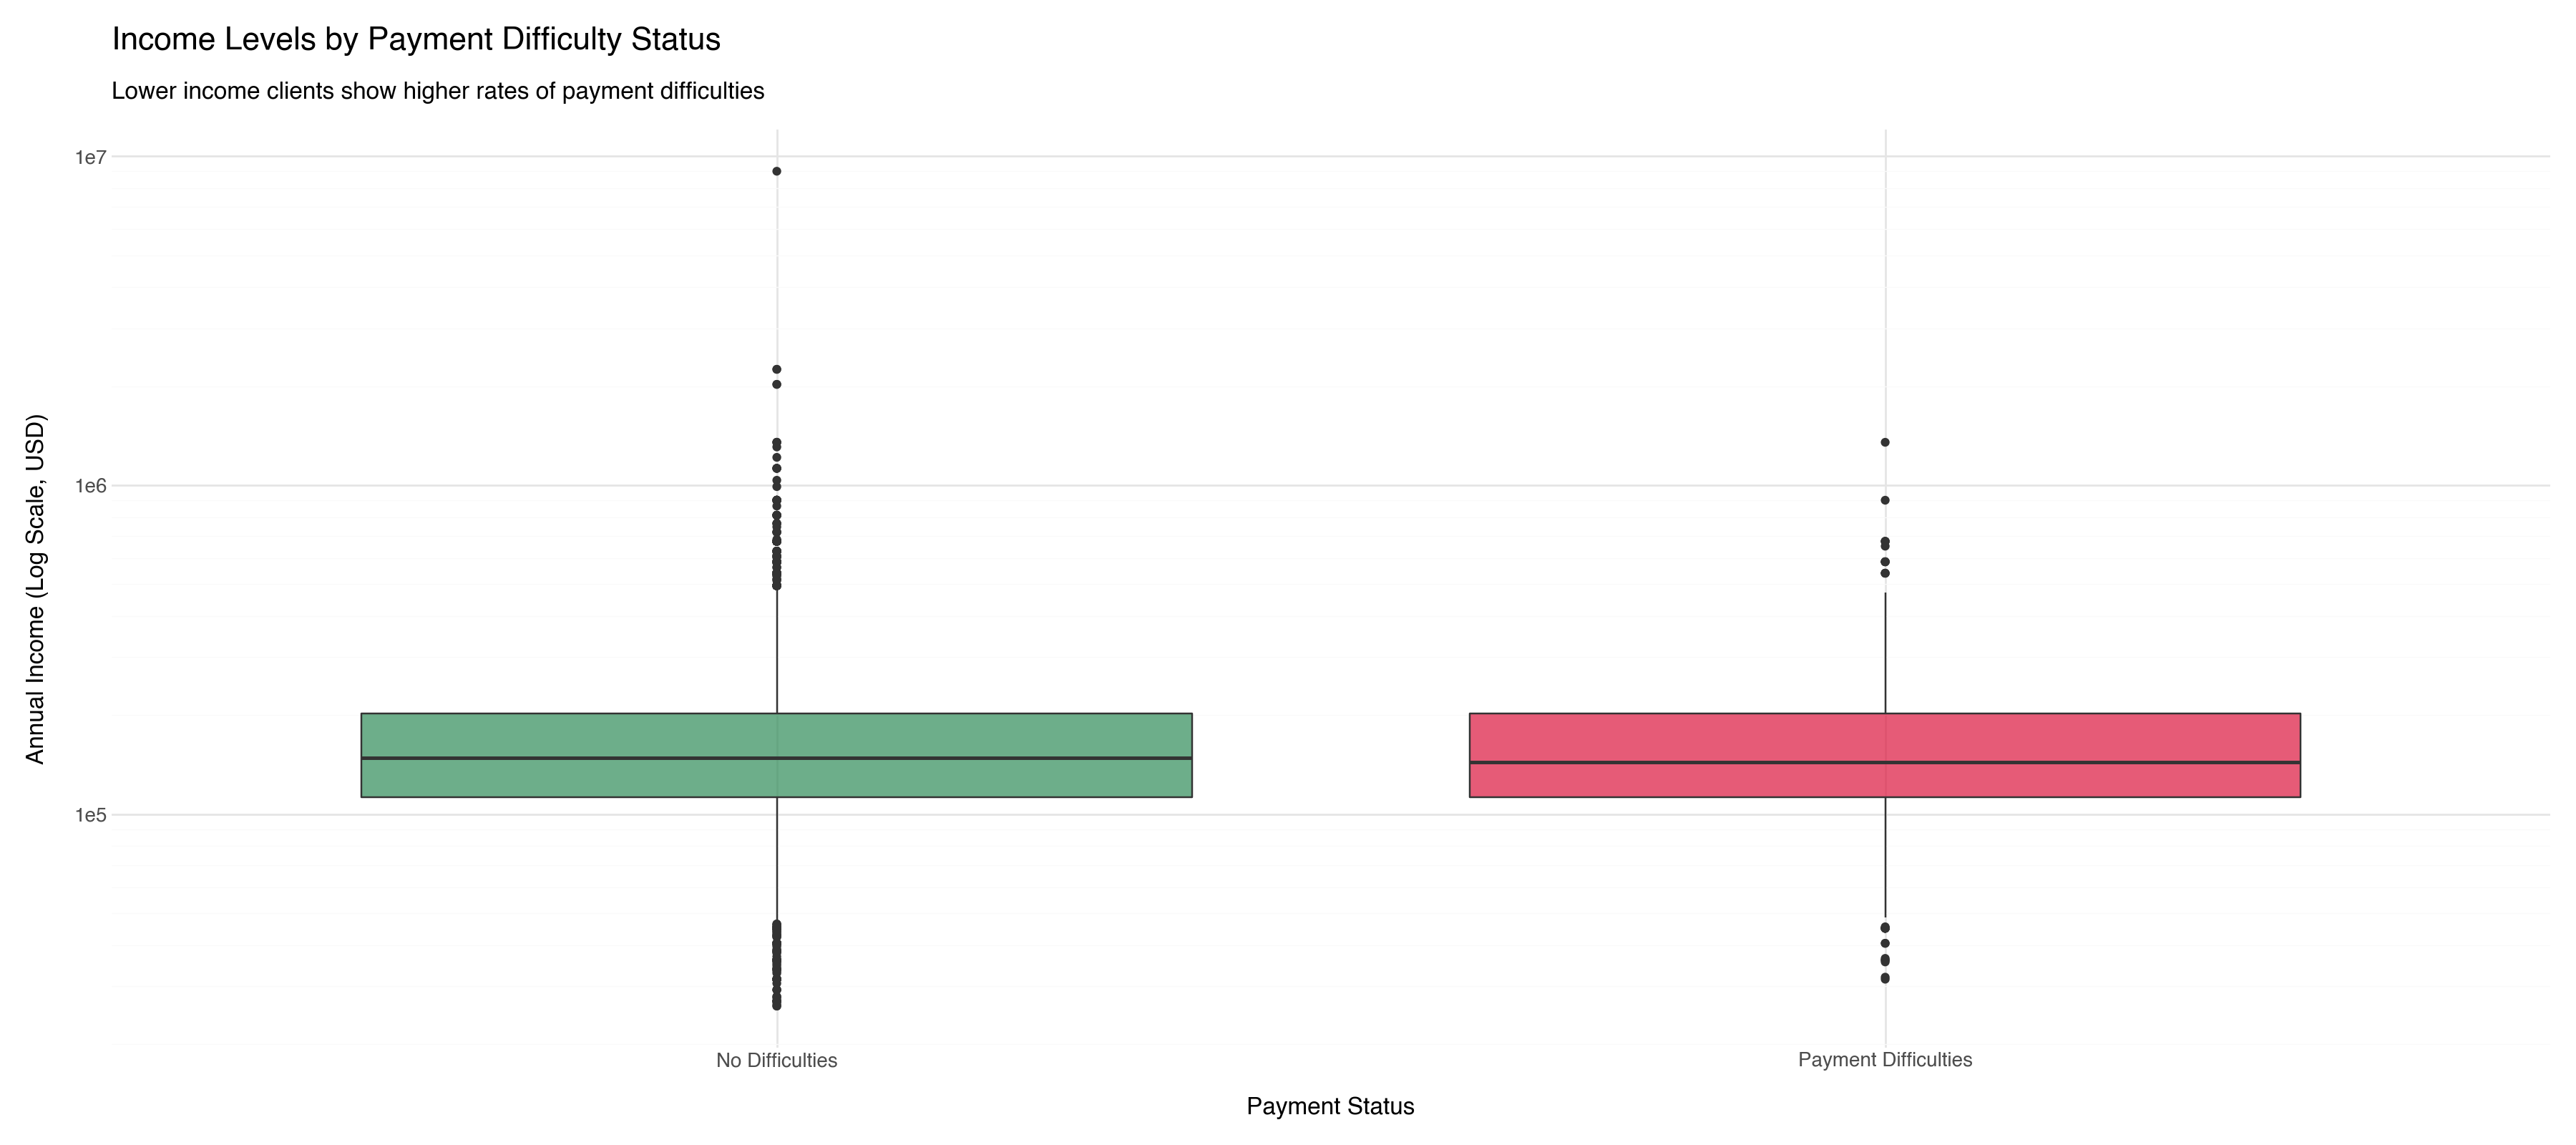

In [20]:
# Response variable relationship - Income by payment status
income_data = (df[df['AMT_INCOME_TOTAL'].notna() & (df['AMT_INCOME_TOTAL'] > 0)]
               .assign(Target_Label=lambda x: x['TARGET'].map({0: 'No Difficulties', 1: 'Payment Difficulties'})))

# Create boxplot comparing income levels between successful and struggling borrowers
plot = (ggplot(income_data, aes(x='Target_Label', y='AMT_INCOME_TOTAL', fill='Target_Label')) +
        geom_boxplot(alpha=0.7) +
        scale_y_log10() +  # Log scale for better visualization of income ranges
        scale_fill_manual(values={'No Difficulties': '#2E8B57', 'Payment Difficulties': '#DC143C'}) +
        labs(title='Income Levels by Payment Difficulty Status',
             subtitle='Lower income clients show higher rates of payment difficulties',
             x='Payment Status',
             y='Annual Income (Log Scale, USD)',
             fill='Status') +
        theme(legend_position='none'))
plot

**Purpose**: This compares the income levels of people who successfully paid back their loans versus those who struggled with payments - basically, does money matter?

**Business Takeaway**: Yes, it really matters! People with lower incomes are much more likely to have trouble paying back loans. This tells us we need to be extra careful with loan amounts for lower-income borrowers and maybe offer them additional support or financial guidance.


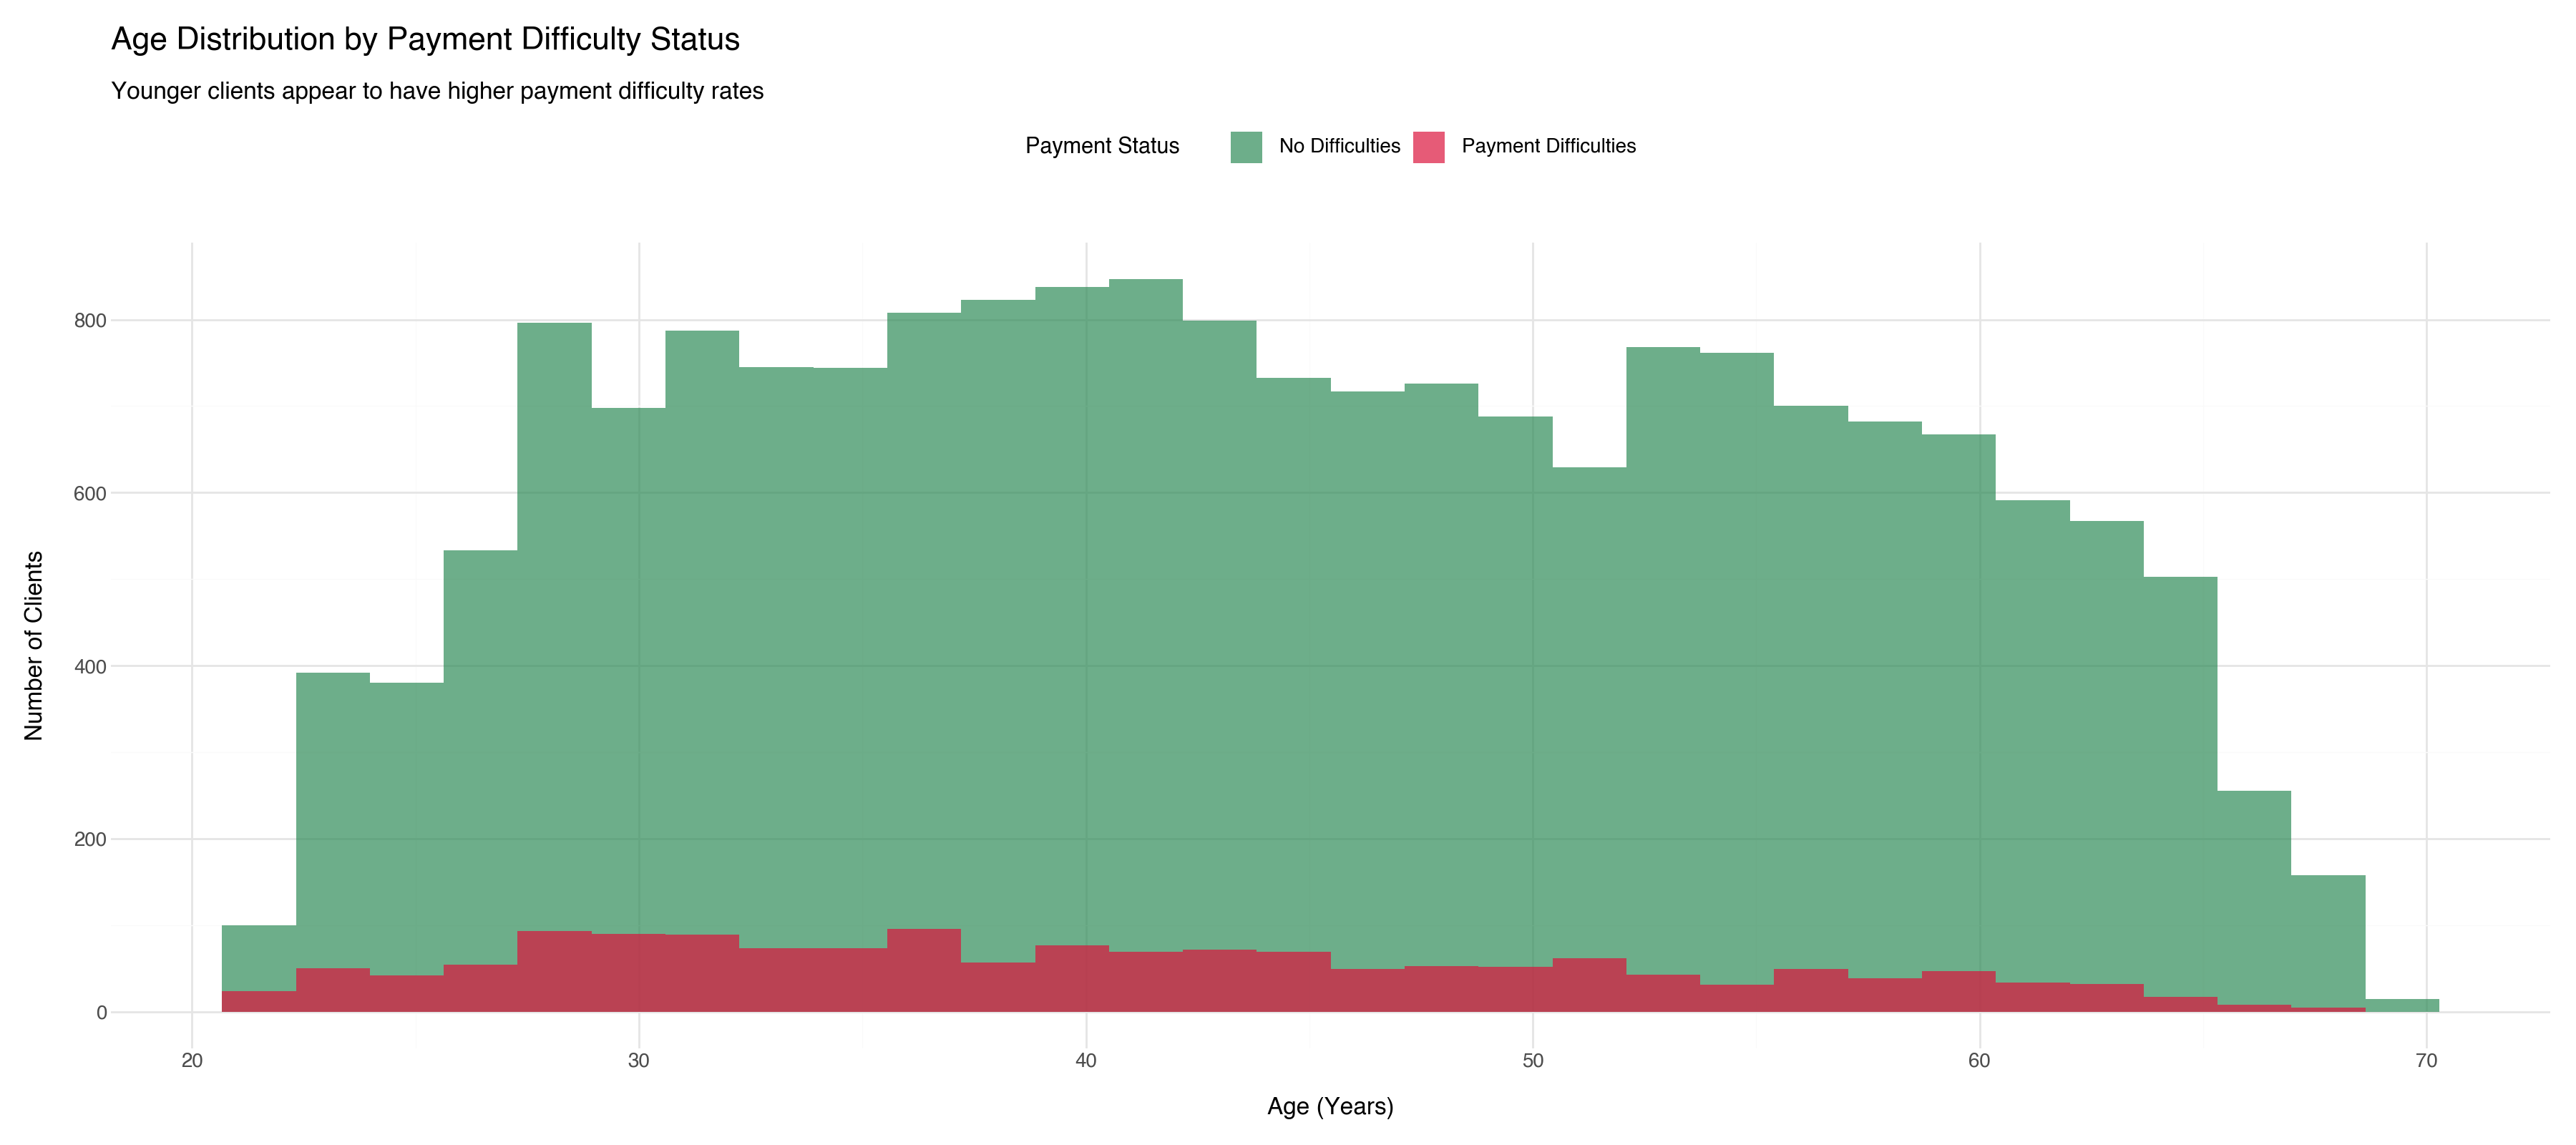

In [21]:
# Response variable relationship - Age analysis
# First, prepare the age data (convert from days to years)
age_data = (df[df['DAYS_BIRTH'].notna()]
            .assign(
                Age_Years=lambda x: abs(x['DAYS_BIRTH']) / 365.25,  # Convert days to years
                Target_Label=lambda x: x['TARGET'].map({0: 'No Difficulties', 1: 'Payment Difficulties'})
            )
            .query('Age_Years >= 18 & Age_Years <= 80'))  # Filter to reasonable age range

# Create histogram showing age distribution by payment status
plot = (ggplot(age_data, aes(x='Age_Years', fill='Target_Label')) +
        geom_histogram(bins=30, alpha=0.7, position='identity') +
        scale_fill_manual(values={'No Difficulties': '#2E8B57', 'Payment Difficulties': '#DC143C'}) +
        labs(title='Age Distribution by Payment Difficulty Status',
             subtitle='Younger clients appear to have higher payment difficulty rates',
             x='Age (Years)', 
             y='Number of Clients', 
             fill='Payment Status') +
        theme(legend_position='top'))

plot

**Purpose**: This looks at whether age makes a difference in loan repayment - are younger or older borrowers more reliable?

**Business Takeaway**: Experience really does matter! Younger people (especially those under 30) struggle more with loan payments than older, more experienced borrowers. This suggests we should provide extra support and guidance for younger borrowers, maybe even requiring financial education or mentorship programs.


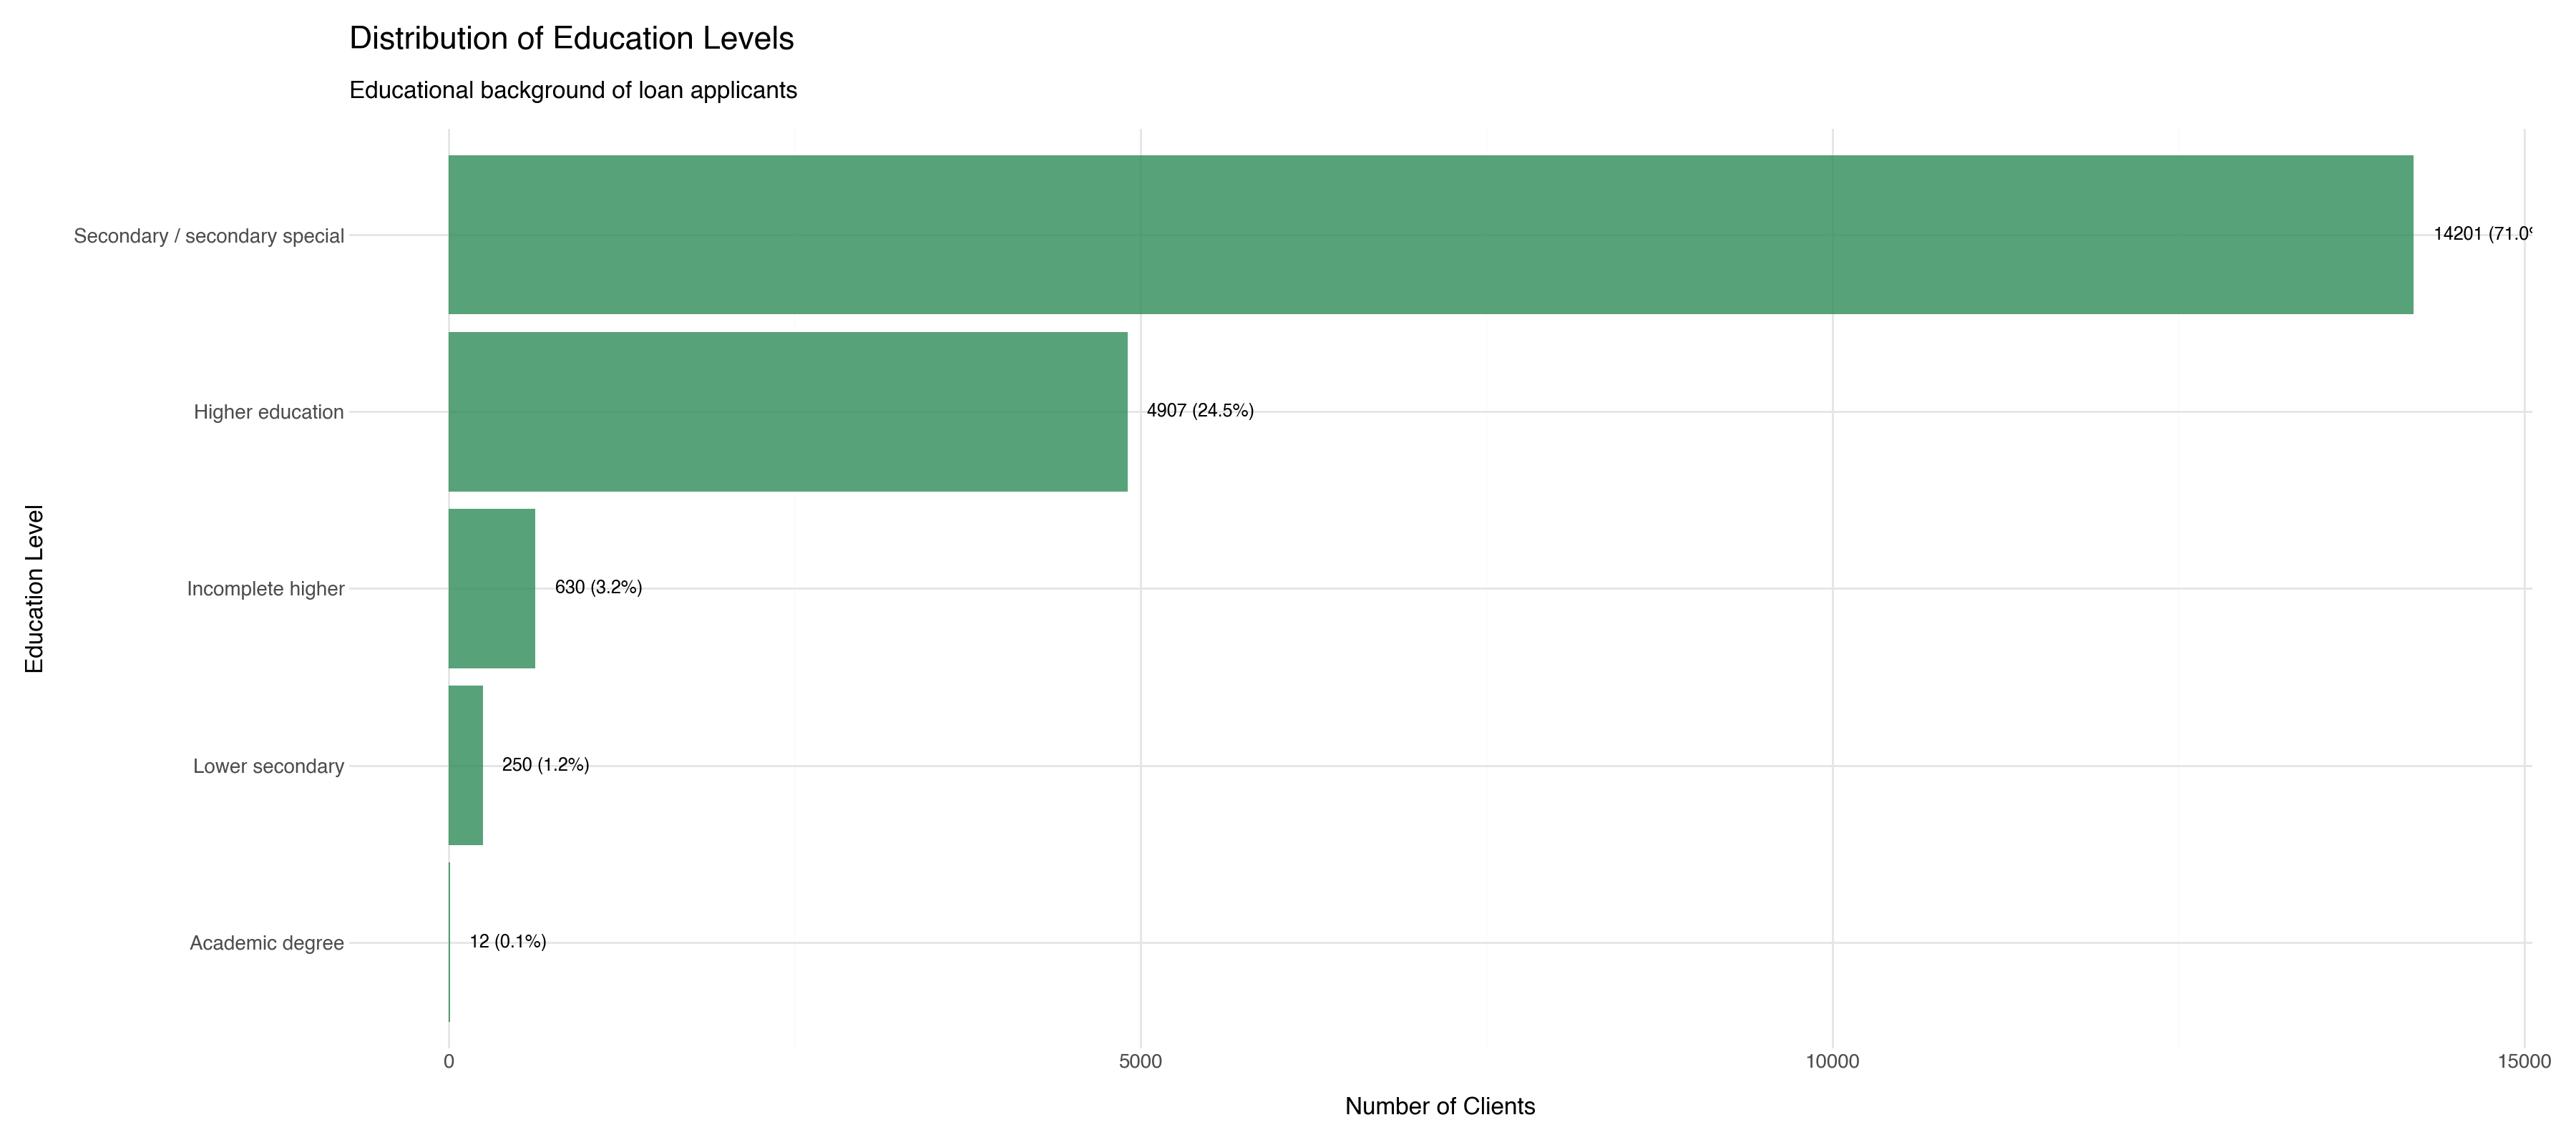

In [22]:
# Single variable analysis - Education distribution
education_data = (df[df['NAME_EDUCATION_TYPE'].notna()]
                 .groupby('NAME_EDUCATION_TYPE')
                 .size()
                 .reset_index(name='count')
                 .assign(percentage=lambda x: round(x['count'] / x['count'].sum() * 100, 1)))

# Add formatted labels for display on chart
education_data['label_text'] = (education_data['count'].astype(str) + 
                               ' (' + education_data['percentage'].astype(str) + '%)')

# Create horizontal bar chart showing education levels
plot = (ggplot(education_data, aes(x='reorder(NAME_EDUCATION_TYPE, count)', y='count')) +
        geom_col(fill='#2E8B57', alpha=0.8) +
        geom_text(aes(label='label_text'), 
                 ha='left', nudge_y=education_data['count'].max() * 0.01, size=9) +
        coord_flip() +  # Make it horizontal for better readability
        labs(title='Distribution of Education Levels',
             subtitle='Educational background of loan applicants',
             x='Education Level',
             y='Number of Clients'))

plot

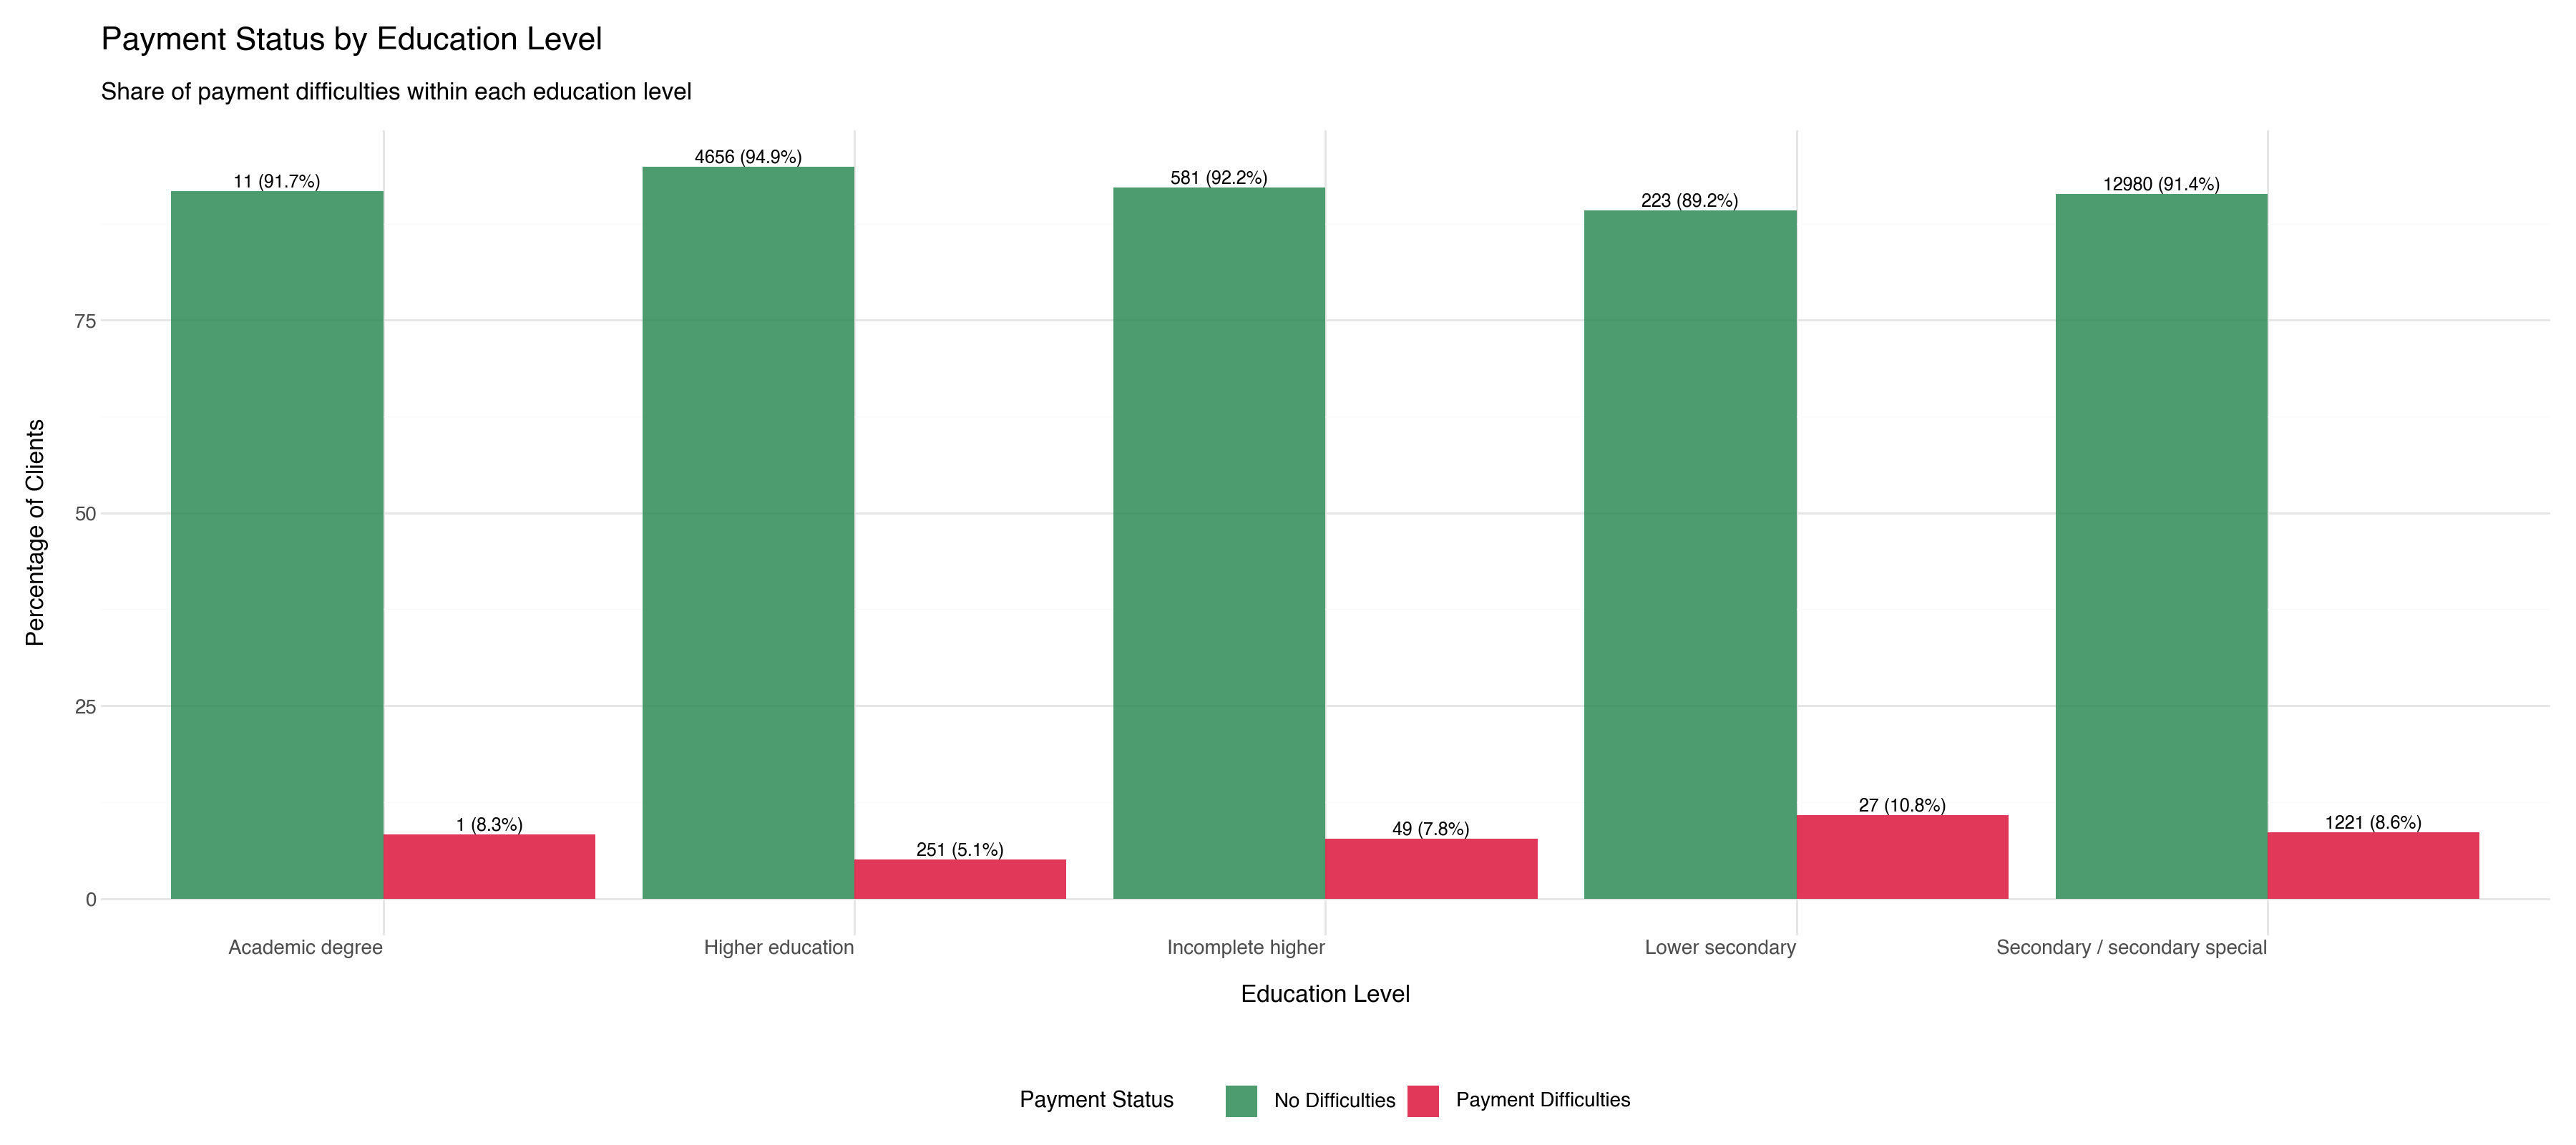

In [23]:
# Education vs TARGET (grouped % bars) + labels
education_target = (
    df[df['NAME_EDUCATION_TYPE'].notna()]
      .groupby(['NAME_EDUCATION_TYPE', 'TARGET'])
      .size()
      .reset_index(name='count')
)

# Percent within each education level (so pct_0 + pct_1 = 100 per group)
education_target['percentage'] = (
    education_target
    .groupby('NAME_EDUCATION_TYPE')['count']
    .transform(lambda g: (g / g.sum() * 100).round(1))
)

# Map target to nice label
education_target['Target_Label'] = education_target['TARGET'].map({
    0: 'No Difficulties', 
    1: 'Payment Difficulties'
})

# Label string: "count (xx.x%)"
education_target['label_text'] = (
    education_target['count'].astype(int).astype(str) + 
    ' (' + education_target['percentage'].astype(str) + '%)'
)

plot = (
    ggplot(education_target, aes(x='NAME_EDUCATION_TYPE', y='percentage', fill='Target_Label')) +
    geom_col(position='dodge', alpha=0.85) +
    geom_text(
        aes(label='label_text'),
        position=position_dodge(width=0.9),
        va='bottom',
        size=9
    ) +
    scale_fill_manual(values={'No Difficulties': '#2E8B57', 'Payment Difficulties': '#DC143C'}) +
    labs(
        title='Payment Status by Education Level',
        subtitle='Share of payment difficulties within each education level',
        x='Education Level',
        y='Percentage of Clients',
        fill='Payment Status'
    ) +
    theme(axis_text_x=element_text(hjust=1))
)

plot

**Purpose**: This chart examines the educational background distribution to understand the demographic profile of loan applicants.

**Business Takeaway**: The majority of clients have secondary education, indicating the lender serves a broad educational demographic. This suggests opportunities for education-level tailored financial products and literacy programs.


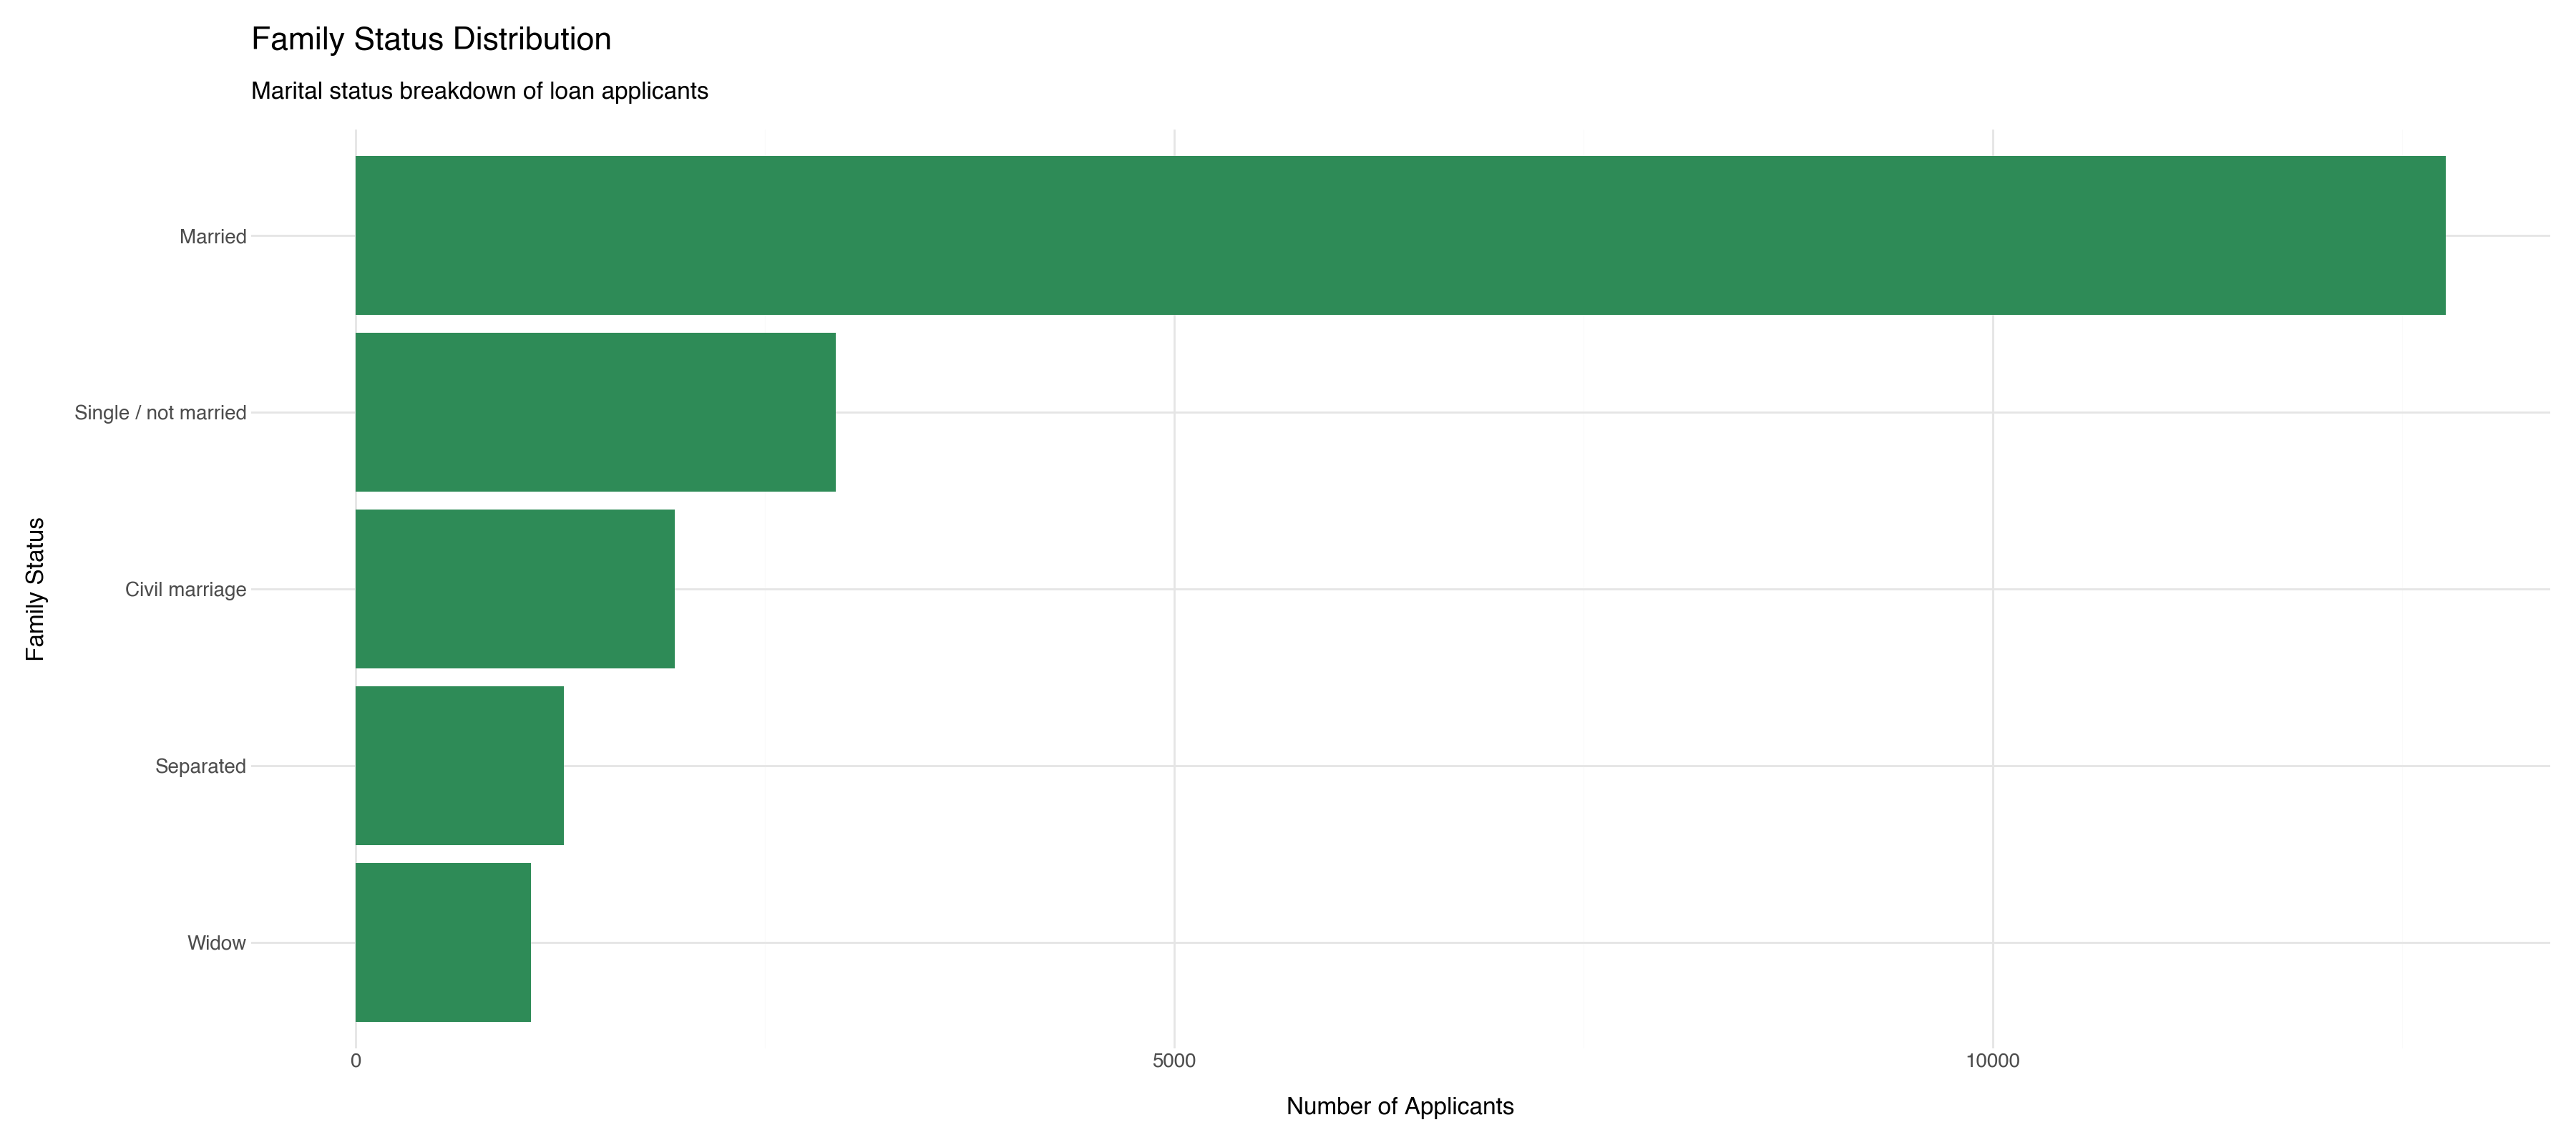

In [24]:
family_data = (
    df[df['NAME_FAMILY_STATUS'].notna()]
      .groupby('NAME_FAMILY_STATUS')
      .size()
      .reset_index(name='count')
      .sort_values('count', ascending=True)
)

# Make NAME_FAMILY_STATUS an ordered categorical
family_data['NAME_FAMILY_STATUS'] = pd.Categorical(
    family_data['NAME_FAMILY_STATUS'],
    categories=family_data['NAME_FAMILY_STATUS'],
    ordered=True
)

plot = (
    ggplot(family_data, aes(x='NAME_FAMILY_STATUS', y='count')) +
    geom_col(fill='#2E8B57') +
    labs(
        title='Family Status Distribution',
        subtitle='Marital status breakdown of loan applicants',
        x='Family Status',
        y='Number of Applicants'
    ) +
    coord_flip()
)

plot


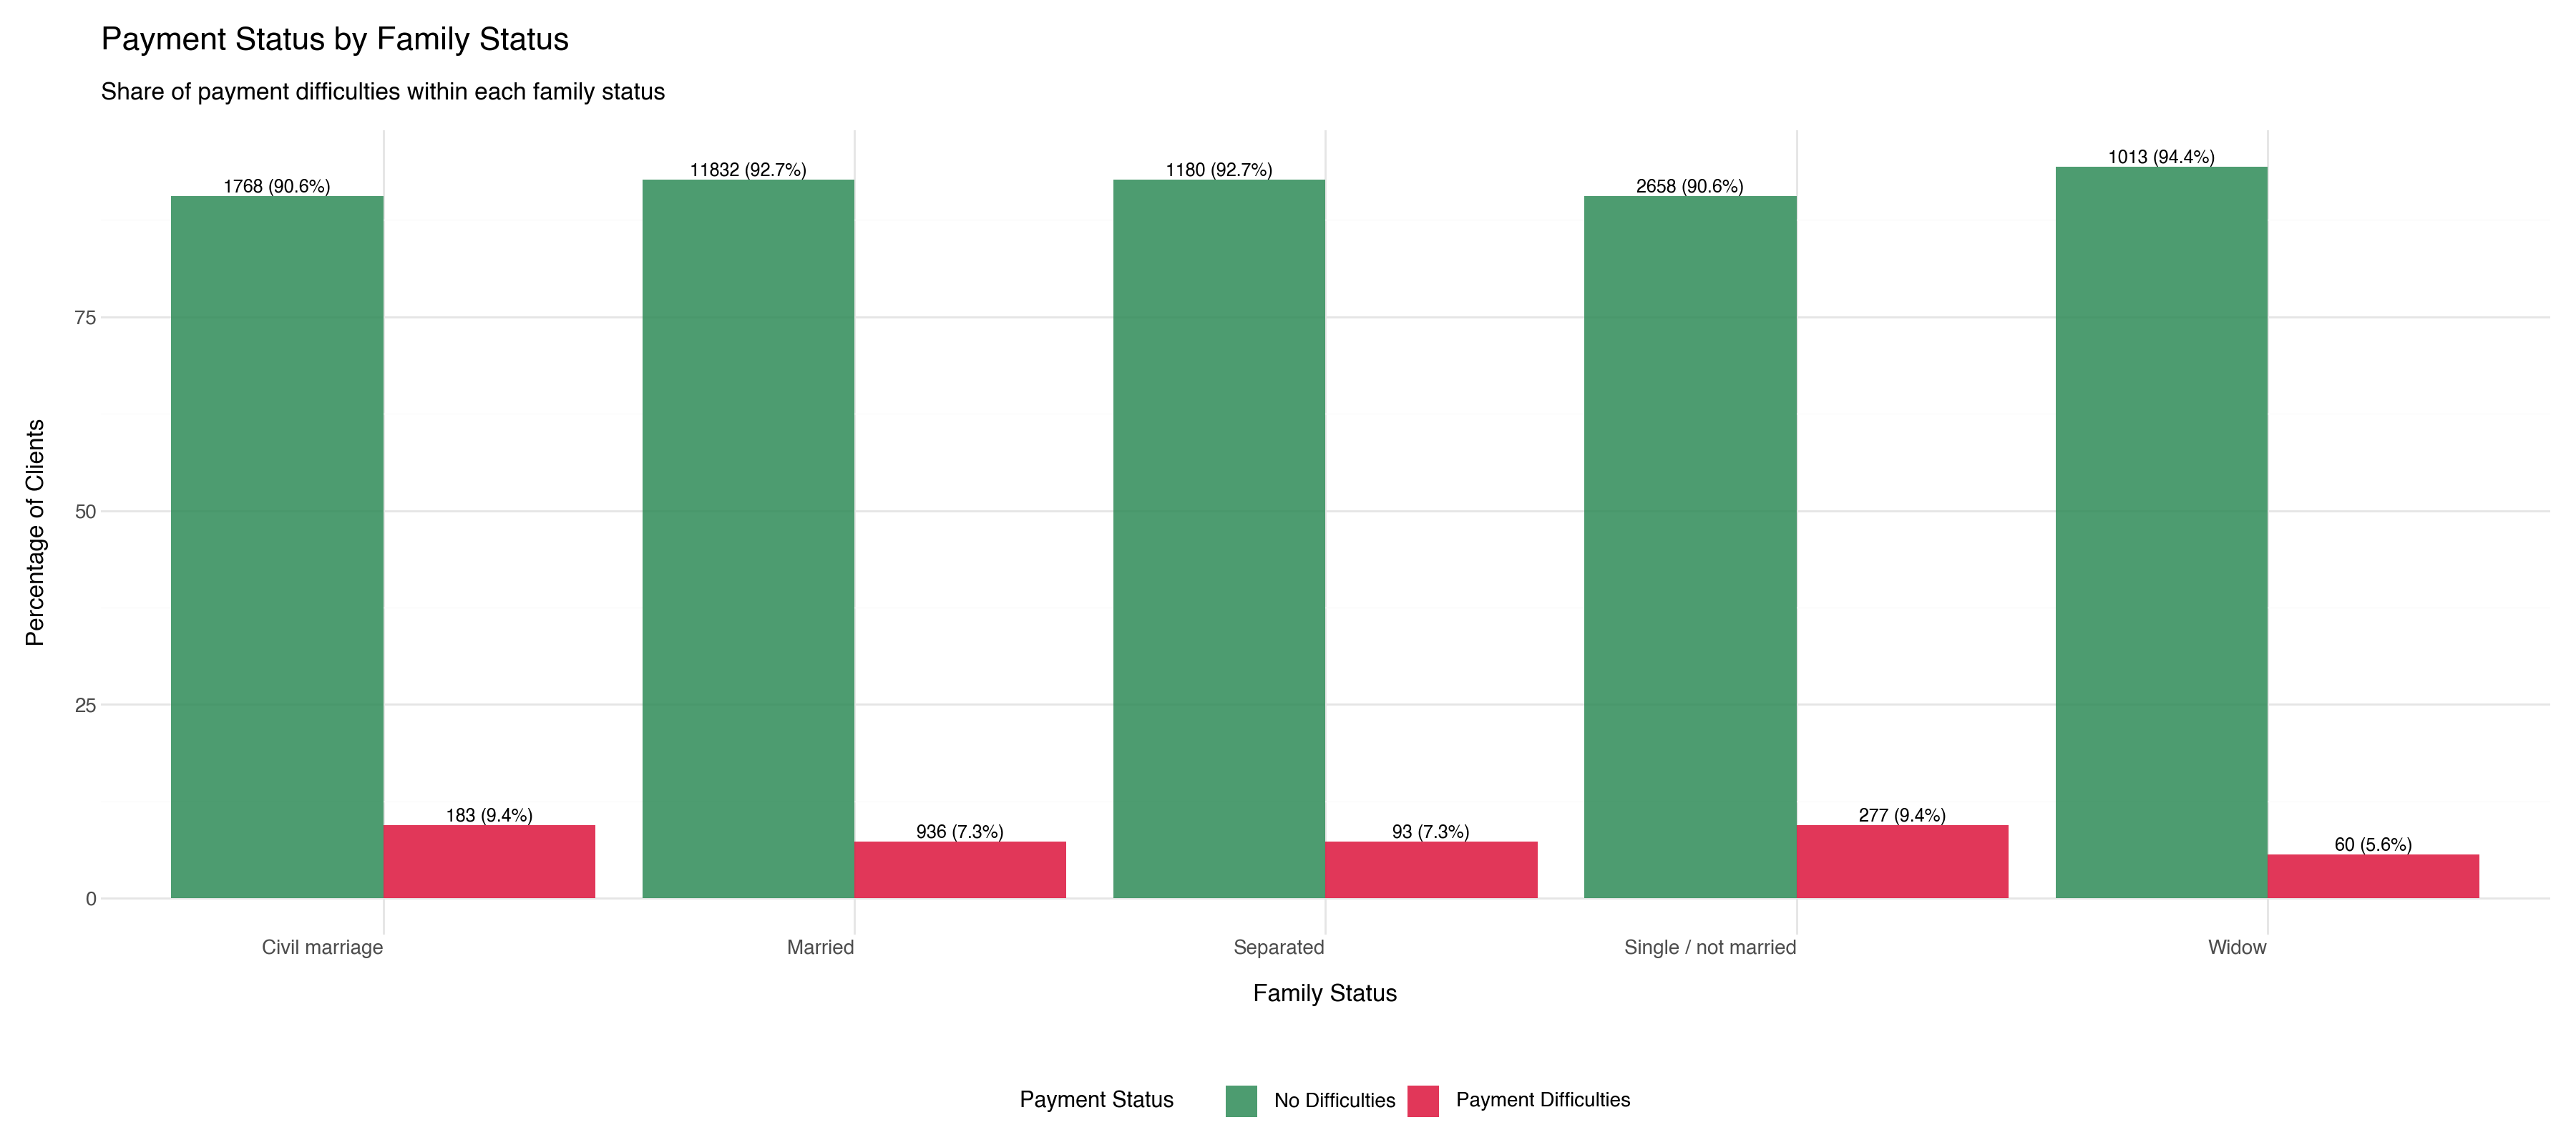

In [25]:
# Family status vs TARGET (grouped % bars) + labels
family_target = (
    df[df['NAME_FAMILY_STATUS'].notna()]
      .groupby(['NAME_FAMILY_STATUS', 'TARGET'])
      .size()
      .reset_index(name='count')
)

# Percent within each family status group (so pct_0 + pct_1 = 100 per status)
family_target['percentage'] = (
    family_target
    .groupby('NAME_FAMILY_STATUS')['count']
    .transform(lambda g: (g / g.sum() * 100).round(1))
)

# Pretty target labels
family_target['Target_Label'] = family_target['TARGET'].map({
    0: 'No Difficulties',
    1: 'Payment Difficulties'
})

# Label string: "count (xx.x%)"
family_target['label_text'] = (
    family_target['count'].astype(int).astype(str) +
    ' (' + family_target['percentage'].astype(str) + '%)'
)

plot = (
    ggplot(family_target, aes(x='NAME_FAMILY_STATUS', y='percentage', fill='Target_Label')) +
    geom_col(position='dodge', alpha=0.85) +
    geom_text(
        aes(label='label_text'),
        position=position_dodge(width=0.9),
        va='bottom',
        size=9
        # Optional: add nudge_y to lift labels slightly above bars (e.g., nudge_y=1)
    ) +
    scale_fill_manual(values={'No Difficulties': '#2E8B57', 'Payment Difficulties': '#DC143C'}) +
    labs(
        title='Payment Status by Family Status',
        subtitle='Share of payment difficulties within each family status',
        x='Family Status',
        y='Percentage of Clients',
        fill='Payment Status'
    ) +
    theme(axis_text_x=element_text(hjust=1))
)

plot

**Purpose**: This pie chart shows the family status composition to understand household structure patterns among applicants.

**Business Takeaway**: Married clients represent a significant portion, suggesting stable household income potential. Single clients may need different risk assessment criteria, while family status could influence loan terms and repayment capacity.


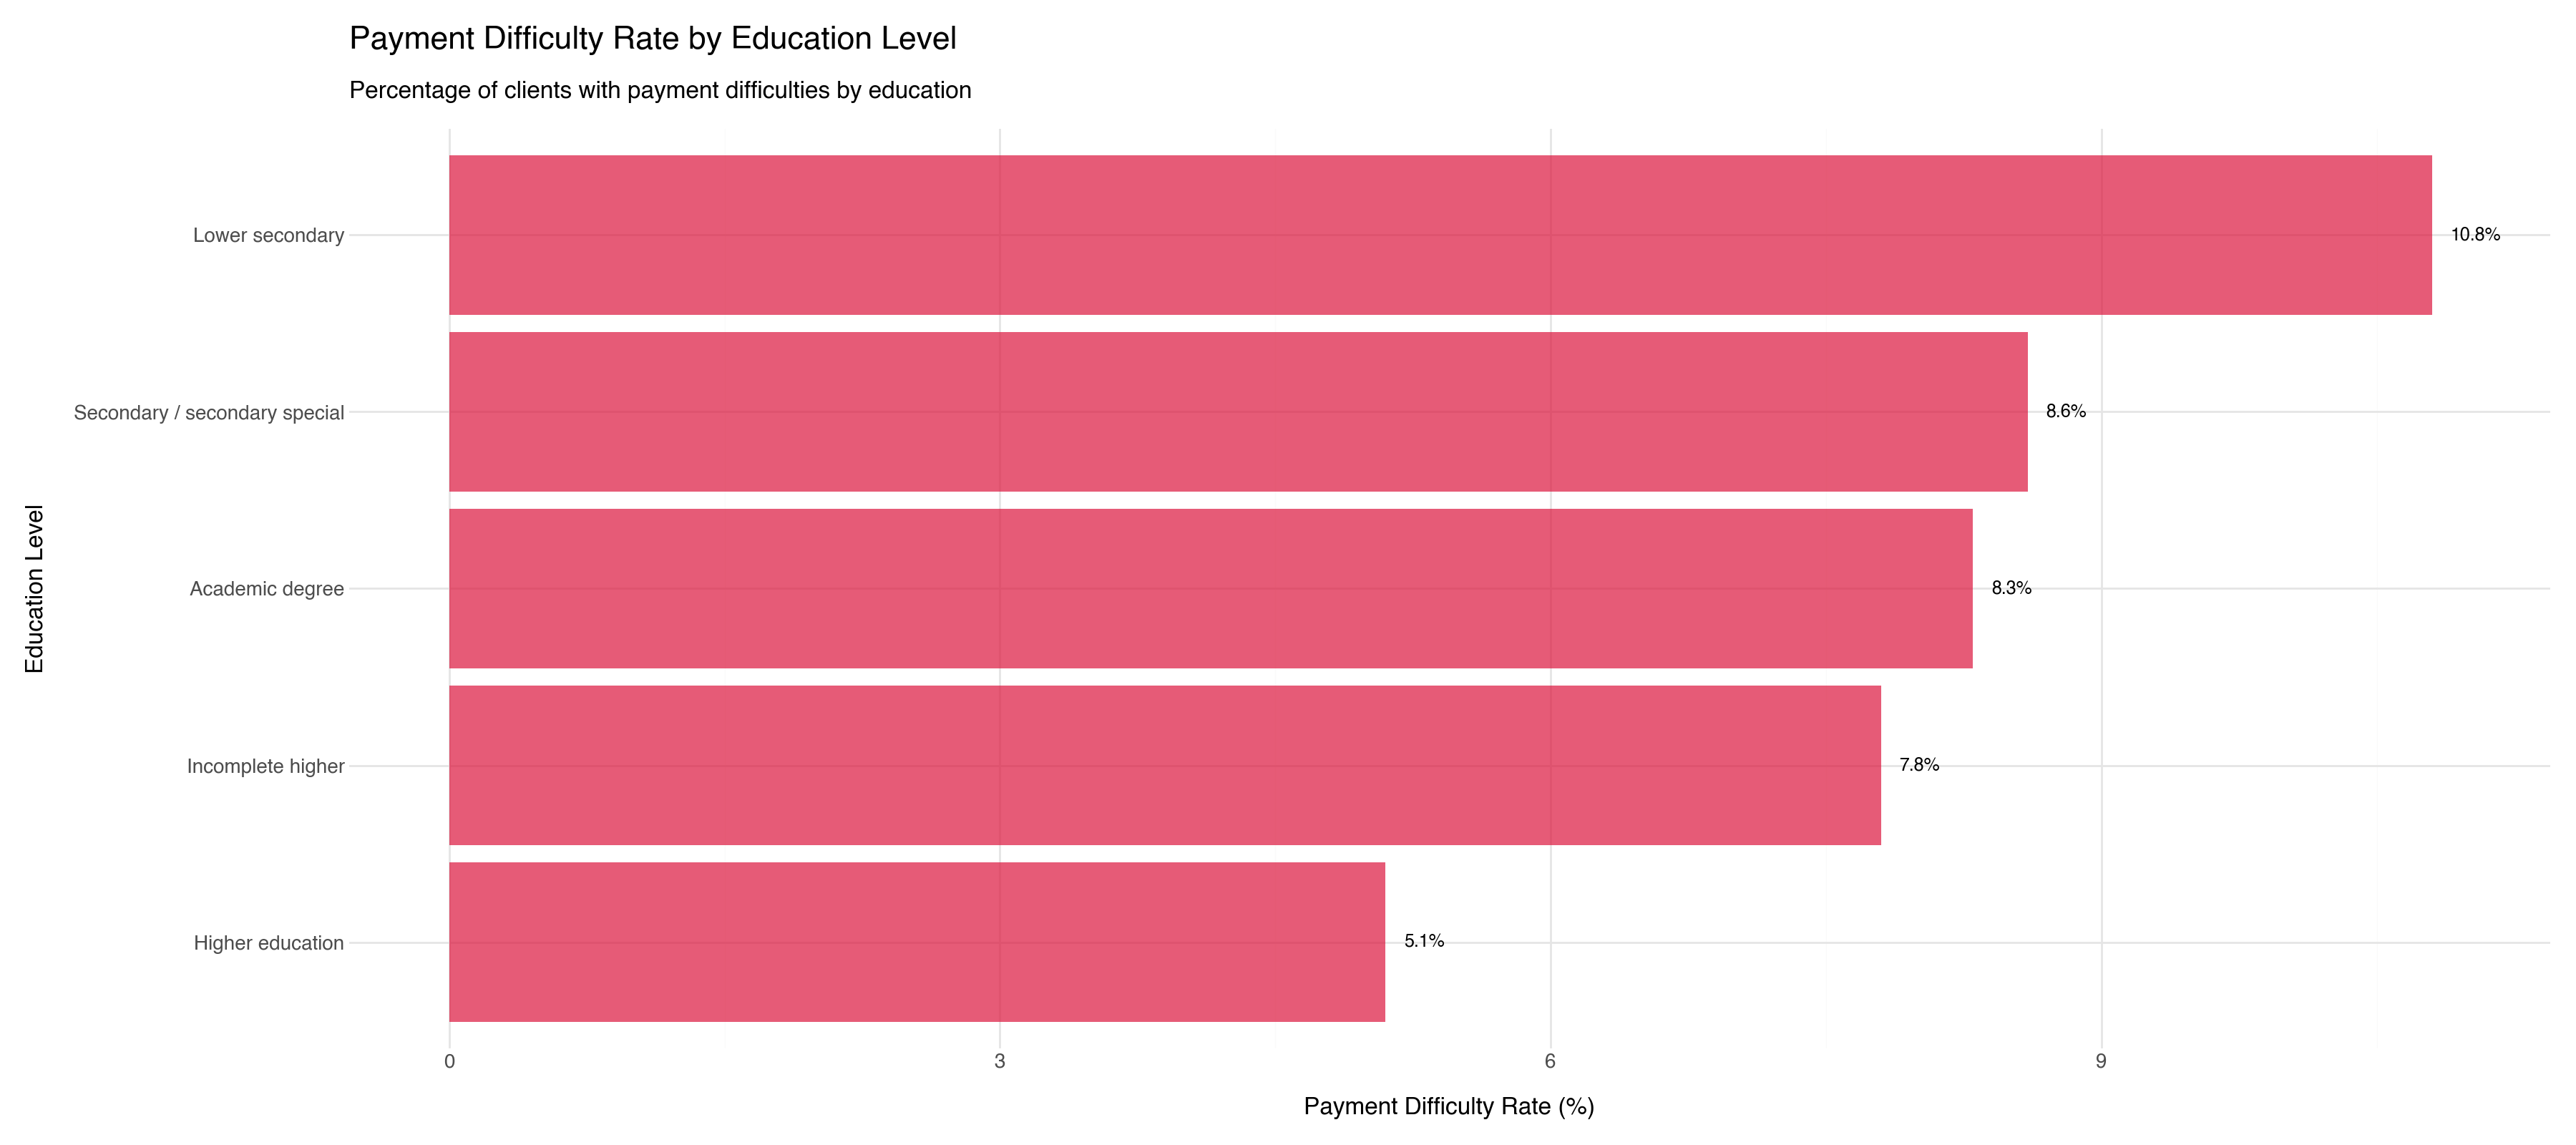

In [26]:
# Education vs target analysis using plotnine (FIXED)
education_target = (df[df['NAME_EDUCATION_TYPE'].notna()]
                   .groupby(['NAME_EDUCATION_TYPE', 'TARGET'])
                   .size()
                   .reset_index(name='count')
                   .pivot(index='NAME_EDUCATION_TYPE', columns='TARGET', values='count')
                   .fillna(0)
                   .assign(total=lambda x: x[0] + x[1])
                   .assign(percentage=lambda x: round(x[1] / x['total'] * 100, 1))
                   .reset_index()
                   .sort_values('percentage'))

# Add formatted labels (FIXED)
education_target['label_text'] = education_target['percentage'].astype(str) + '%'

plot = (ggplot(education_target, aes(x='reorder(NAME_EDUCATION_TYPE, percentage)', y='percentage')) +
        geom_col(fill='#DC143C', alpha=0.7) +
        geom_text(aes(label='label_text'), ha='left', nudge_y=0.1, size=9) +
        coord_flip() +
        labs(title='Payment Difficulty Rate by Education Level',
             subtitle='Percentage of clients with payment difficulties by education',
             x='Education Level',
             y='Payment Difficulty Rate (%)'))
plot

**Purpose**: This chart analyzes how education level correlates with payment difficulty rates to identify education-based risk patterns.

**Business Takeaway**: Higher education levels show lower default rates, suggesting education is a protective factor. This indicates potential for education-based pricing or approval criteria, and highlights opportunities for financial education programs for lower-educated segments.


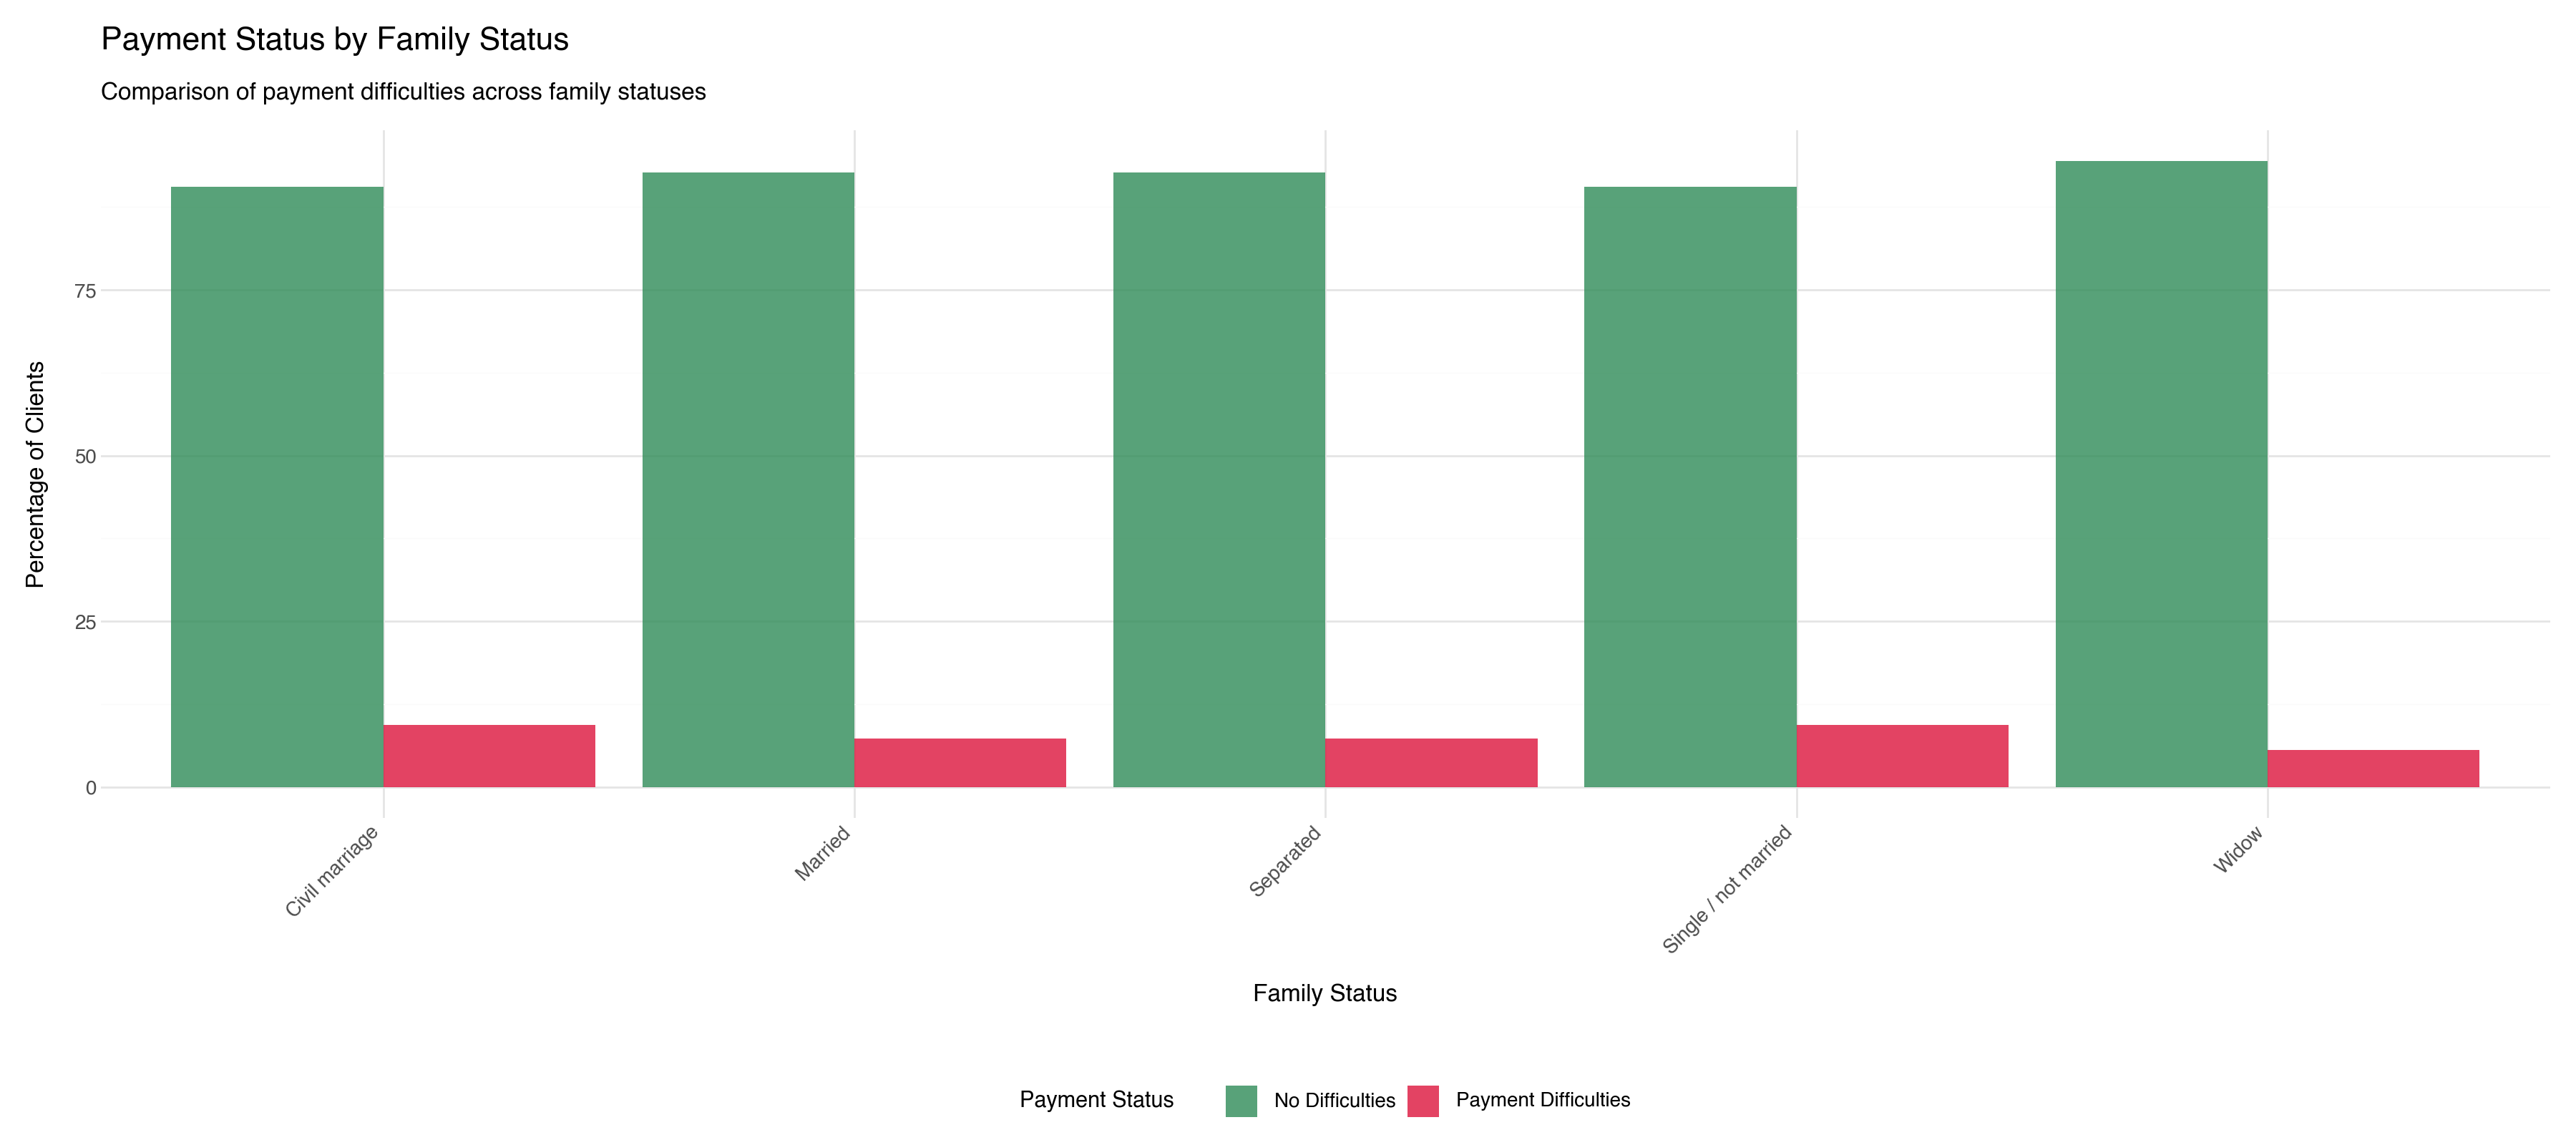

In [27]:
# Family status vs target analysis using plotnine (FIXED)
family_target = (df[df['NAME_FAMILY_STATUS'].notna()]
                .groupby(['NAME_FAMILY_STATUS', 'TARGET'])
                .size()
                .reset_index(name='count')
                .pivot(index='NAME_FAMILY_STATUS', columns='TARGET', values='count')
                .fillna(0)
                .assign(total=lambda x: x[0] + x[1])
                .assign(pct_0=lambda x: round(x[0] / x['total'] * 100, 1))
                .assign(pct_1=lambda x: round(x[1] / x['total'] * 100, 1))
                .reset_index()
                .melt(id_vars=['NAME_FAMILY_STATUS'], 
                      value_vars=['pct_0', 'pct_1'],
                      var_name='TARGET_TYPE', value_name='percentage')
                .assign(Target_Label=lambda x: x['TARGET_TYPE'].map({'pct_0': 'No Difficulties', 'pct_1': 'Payment Difficulties'})))

plot = (ggplot(family_target, aes(x='NAME_FAMILY_STATUS', y='percentage', fill='Target_Label')) +
        geom_col(position='dodge', alpha=0.8) +
        scale_fill_manual(values={'No Difficulties': '#2E8B57', 'Payment Difficulties': '#DC143C'}) +
        labs(title='Payment Status by Family Status',
             subtitle='Comparison of payment difficulties across family statuses',
             x='Family Status',
             y='Percentage of Clients',
             fill='Payment Status') +
        theme(axis_text_x=element_text(rotation=45, hjust=1)))

plot

**Purpose**: This grouped bar chart compares payment difficulty rates across different family statuses to understand relationship stability as a risk factor.

**Business Takeaway**: Married clients show lower default rates compared to single/divorced clients, suggesting relationship stability influences financial stability. This supports using family status as a risk assessment factor and potentially offering family-oriented financial products.


In [28]:
df.shape

(20000, 30)

In [30]:
# save the working dataframe for later use
working_dataframe = df.to_csv("working_dataframe.csv", index=False)